<a href="https://colab.research.google.com/github/kadefue/MoEST/blob/main/MoEST_Modeling_for_Secondary_School.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comprehensive Overview of Secondary School Enrollment Forecasting

This notebook provides a complete pipeline for forecasting secondary school enrollment in Tanzania from 2026 to 2030. The analysis integrates various datasets related to enrollment, dropout rates, re-entry, disabilities, school infrastructure (tables, chairs, ICT, electricity, laboratories), and geographical information.

**The pipeline consists of the following key stages:**

1.  **Data Loading and Initial Inspection**: All relevant CSV files are loaded into pandas DataFrames, and a preliminary inspection of their structure and content is performed.
2.  **Data Cleaning and Standardization**: This stage focuses on ensuring data quality by:
    *   Converting object columns to numeric where appropriate.
    *   Dropping irrelevant 'Unnamed' columns.
    *   Standardizing column names (e.g., 'Year', 'Region', 'Council') to facilitate merging and analysis.
    *   Removing certain datasets (e.g., related to primary education, teachers, population) that are not directly relevant to secondary school enrollment forecasting.
3.  **Geographical Enrichment**: Local Government Authority (LGA) status (Urban/Rural) and geographical coordinates (Latitude, Longitude) are obtained for each council. These coordinates are then used to perform K-Means clustering, categorizing councils into geographical clusters. The LGA status and cluster information are merged into all relevant datasets.
4.  **Feature Engineering**: This is a critical step where raw data is transformed into features suitable for machine learning models. Key features include:
    *   **Cohort Tracking**: Linking students from one form/grade in a given year to the next form/grade in the subsequent year to capture student progression.
    *   **Lagged Enrollment**: Previous years' enrollment figures to model trends.
    *   **Year-over-Year Growth**: Measuring the percentage change in enrollment.
    *   **Infrastructure Ratios**: Features derived from available tables, computers, electricity access, and laboratory facilities.
    *   **Dropout Causes**: Including truancy, pregnancy, and indiscipline.
    *   **Re-entry and Disability Data**: Indicators for re-enrolled students and students with disabilities.
    *   **Temporal Features**: Such as election years, which might influence policy and enrollment.
5.  **Model Training and Evaluation**: Advanced machine learning models, specifically XGBoost and LightGBM, are trained on the prepared historical data (2016-2023). The models' performance is evaluated using metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Percentage Error (MAPE) on a hold-out test set (2024-2025).
6.  **Recursive Forecasting (2026-2030)**: The trained models are used to generate future enrollment predictions. This is done recursively, where predictions for one year become inputs for predicting the next year, mimicking the real-world progression of students.
7.  **Visualization and Interpretation**: The historical and forecasted enrollment trends are visualized through various plots, including:
    *   National-level enrollment trajectory.
    *   Stacked area charts showing enrollment composition by form (Form 1-6).
    *   Bar charts highlighting predicted top regions by enrollment.
    *   Individual trend lines for a randomly selected sample of councils, providing granular insights.
    *   An interactive Folium map displaying geographical clusters and embedding individual council forecast plots for easy exploration.
8.  **Output Generation**: The final forecasts are presented in both long and wide formats and exported to CSV files for further use.

This comprehensive approach aims to provide robust and actionable insights into future secondary school enrollment, supporting strategic planning and resource allocation in the Tanzanian education sector.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This cell mounts Google Drive to access files and imports the pandas library for data manipulation. It's a standard first step in many Colab notebooks that work with external data stored in Drive.

This cell lists the contents of the specified Google Drive folder, showing all the CSV files available for analysis. This helps in understanding the raw data assets.

This cell reads all CSV files from the specified base directory, filters out files containing specific keywords (e.g., 'Primary', 'Textbooks', 'Population', 'Teacher', 'COBET', 'Vocational') to focus on secondary education related data, and then prints the names of the files that will be processed.

This cell iterates through the `filtered_files` list, loads each CSV file into a pandas DataFrame, and stores these DataFrames in a dictionary called `loaded_dataframes`. The DataFrame's name (without the `.csv` extension) is used as the key for the dictionary.

This cell provides a quick overview of each loaded DataFrame. For each DataFrame, it prints the first 5 rows using `.head()` and a summary of its structure and data types using `.info()`. This helps in understanding the initial state and content of the data.

This cell performs general cleaning on all loaded DataFrames. It attempts to convert 'object' type columns to numeric if they contain numerical data (e.g., strings with commas), and it drops 'Unnamed: X' columns that are mostly empty (more than 90% null values). This improves data quality and prepares it for further analysis.

This cell checks for inconsistencies in core columns ('Year', 'Region', 'Council') across all DataFrames. It verifies data types (numeric for 'Year', object for 'Region'/'Council') and checks for the presence of null values. This early check helps identify potential issues before merging or analysis.

This cell removes DataFrames from the `loaded_dataframes` dictionary that contain the keywords 'Teacher' or 'Population' in their names. This further refines the dataset to include only information relevant to the current secondary school enrollment forecasting task.

This cell specifically processes the 'LGAs Urban and Rural Status' DataFrame. It drops the 'Remarks' column, renames 'Classification' to 'LGA_Status', and converts 'Region' and 'Council' columns to uppercase for consistent merging with other DataFrames. This DataFrame will be used to enrich other datasets with urban/rural classification.

This cell merges the `LGA_Status` (Urban/Rural classification) into all other relevant DataFrames in `loaded_dataframes`. It iterates through each DataFrame, standardizes its 'Region' and 'Council' column names and values, and then performs a left merge with `df_lga_status`. This enriches the main datasets with geographical classification.

This cell re-checks for inconsistencies in core columns ('Year', 'Region', 'Council') after the `LGA_Status` merge. It identifies missing columns, inconsistent data types, and null values. This step is crucial to ensure that the merged data is clean and ready for further processing and model training.

This cell explicitly removes the `LGAs Urban and Rural Status` DataFrame from the `loaded_dataframes` dictionary, as its information has already been merged into other relevant DataFrames and it's no longer needed as a standalone DataFrame.

This cell attempts to remove a DataFrame named 'Pre-primary GER NA NER 2017-2025'. Based on the previous filtering steps, this DataFrame might already be absent, but this ensures it's not present if it somehow slipped through.

This cell addresses the null values found in 'Region' and 'Council' columns identified in the previous consistency check. It iterates through each DataFrame and drops rows where these critical identifier columns have null values, ensuring clean geographical keys for all entries.

This cell dynamically identifies core columns (Year, Region, Council) and all other numerical metric columns for each DataFrame. This structured identification helps in later stages for feature selection and ensuring that modeling processes correctly target relevant data.

This cell performs geographical data enrichment. It consolidates unique Region-Council combinations, generates search queries, uses `geopy` with `Nominatim` to fetch latitude and longitude coordinates, and then saves this geodata to a CSV file to avoid repeated API calls. If the geodata file exists, it loads it instead of re-fetching.

This cell applies K-Means clustering to the geographical coordinates (Latitude, Longitude) obtained from the previous step. It groups regions/councils into `n_clusters` (e.g., 5 clusters) based on their geographical proximity, assigning a `Geo_Cluster` label to each location. This adds a new categorical feature that can capture spatial patterns.

This cell merges the `Geo_Cluster` information (derived from K-Means clustering) back into all other relevant DataFrames in `loaded_dataframes`. Similar to the `LGA_Status` merge, it uses 'Region' and 'Council' as keys to enrich each DataFrame with its assigned geographical cluster.

This cell serves as a verification step. It selects a few sample DataFrames (e.g., 'Data-Secondary Enrollment 2016-2025') and prints their head and info to confirm that the `LGA_Status` and `Geo_Cluster` columns have been successfully merged and that their data types are correct.

This cell performs an initial analysis of key numerical metrics grouped by the newly created `Geo_Cluster`. For selected DataFrames and metrics, it calculates descriptive statistics (mean, median, standard deviation) for each geographical cluster. This helps in understanding the characteristics and differences across clusters before modeling.

This cell imports `matplotlib.pyplot` and `seaborn`, which are essential libraries for creating visualizations in Python. It's a preparatory step for generating plots in subsequent cells.

This cell generates visualizations to explore the characteristics of the geographical clusters. It produces bar plots showing the mean of selected metrics for each cluster and box plots illustrating the distribution of these metrics across clusters. This helps in understanding what defines each cluster in terms of the analyzed data.

This cell generates a scatter plot of all unique geographical locations (regions/councils) in Tanzania, colored by their assigned `Geo_Cluster`. This visualization helps to geographically understand the distribution and spatial grouping of the clusters identified by K-Means.

This cell generates an interactive Folium map, centered on Tanzania, and overlays markers for all unique geographical locations. Each marker provides a tooltip with the council name and an interactive popup showing the region and council. This map visually represents the geographical scope of the data.

This cell identifies all numerical columns in each DataFrame that are candidates for outlier treatment. It filters out common identifier columns (like 'Year', 'Region_ENC', 'Geo_Cluster') to ensure that only actual metric columns are considered for outlier detection and handling.

This cell provides a final overview of all DataFrames in `loaded_dataframes`, printing their `.info()` output. This helps to confirm the current state of each DataFrame, including column names, non-null counts, and data types, after all the cleaning and merging operations.

This comprehensive cell defines and executes the core pipeline for secondary school enrollment forecasting. It includes:

1.  **`standard_cols`**: A helper function to standardize column names (uppercase, strip whitespace).
2.  **`prepare_secondary_datasets`**: Cleans and reshapes enrollment data (wide to long), and aggregates key features from various datasets (re-entry, disability, infrastructure) per year/region/council.
3.  **`engineer_secondary_features`**: Merges all prepared datasets, creates temporal features (election year, lagged enrollment, year-over-year growth), and implements a crucial 'cohort logic' to track student progression across forms/years.
4.  **`calculate_metrics`**: Evaluates model performance using MAE, RMSE, R2, and MAPE.
5.  **`train_secondary_models`**: Splits data into training and testing sets (up to 2023 for training, 2024-2025 for testing), trains XGBoost and LightGBM models, and returns their evaluation metrics.
6.  **`run_secondary_pipeline`**: Orchestrates the entire process from data preparation to model training and evaluation.

Finally, the cell executes the `run_secondary_pipeline` function using the relevant DataFrames from `loaded_dataframes` to generate the initial model training and evaluation results.

This cell defines the functions necessary for generating recursive forecasts for secondary school enrollment from 2026 to 2030:

1.  **`create_next_year_secondary_features`**: A helper function that takes the previous year's data and projects features for the next year. It's crucial for the recursive nature of the forecast, handling lags, year-over-year growth, cohort progression across forms, and carrying forward infrastructure features.
2.  **`generate_secondary_forecasts`**: This is the core forecasting engine. It iteratively predicts enrollment for each year from 2026 to 2030. For each year, it uses the `create_next_year_secondary_features` function to prepare the input, makes predictions using an ensemble of XGBoost and LightGBM, and then uses these predictions as the 'history' for the next year's forecast.
3.  **`run_secondary_prediction_pipeline`**: This wrapper function first retrains the XGBoost and LightGBM models on the *full historical dataset* (2016-2025) to maximize their predictive power before generating the actual forecasts. It then calls `generate_secondary_forecasts` and formats the output.

Finally, the cell executes `run_secondary_prediction_pipeline` using the `secondary_final_df` (the fully prepared historical dataset) to generate the future enrollment forecasts.

This cell defines and executes `plot_secondary_forecasts`, a function designed to visualize the historical and forecasted secondary school enrollment trends. It generates three types of plots:

1.  **National Enrollment Trajectory**: A line plot showing the total secondary enrollment from 2016 to 2030, distinguishing between historical actuals and future forecasts.
2.  **Enrollment Composition by Form**: A stacked area chart illustrating how the enrollment is distributed across Forms 1-6 over time (specifically from 2020-2030), showing shifts in cohort sizes.
3.  **Top 10 Regions in 2030**: A horizontal bar chart displaying the predicted total enrollment for the top 10 regions in 2030.

These visualizations provide a clear and intuitive understanding of the overall trends, structural changes, and regional variations in secondary school enrollment.

This cell serves as the master execution block for the entire secondary school enrollment forecasting pipeline. It orchestrates the following key steps:

1.  **Training Models**: Calls `run_secondary_pipeline` to prepare data and train initial models on the historical data (2016-2025).
2.  **Generating Forecasts**: Calls `run_secondary_prediction_pipeline` to retrain models on the full historical dataset and then generate recursive forecasts for 2026-2030.
3.  **Previewing Data**: Prints the first 10 rows of the generated `future_secondary_enrollment` DataFrame to show a sample of the forecast.
4.  **Plotting and Saving Visualizations**: Invokes `plot_secondary_forecasts` (which was defined in the previous cell) to create and display the trend charts, and implicitly saves them as image files.
5.  **Exporting Data**: Saves the complete `future_secondary_enrollment` DataFrame to a CSV file named `Tanzania_MoEST_Secondary_Forecast_2026_2030.csv`.

This cell re-defines and executes the `plot_secondary_forecasts` function. The key difference here is that this version *explicitly saves* the generated plots to PNG files (`Secondary_Forecast_National_Trend.png` and `Secondary_Forecast_Form_Composition.png`) in addition to displaying them. This ensures that the visualizations are preserved as static images.

This cell transforms the 'long' format secondary forecast DataFrame (`future_secondary_enrollment`) into a 'wide' format. In the wide format, years (2026-2030) become column headers, making it easier to see enrollment figures for a specific region, council, and form across different forecast years. The data is then sorted and exported to a CSV file named `Tanzania_Secondary_Forecast_2026_2030_WIDE.csv`.

This cell focuses on visualizing the feature importance of the trained XGBoost and LightGBM models. It modifies the `train_secondary_models` function to return both trained model objects. It then defines a `plot_feature_importance` function that extracts and plots the top 15 most important features for each model. This helps in understanding which factors (e.g., lagged enrollment, cohort data, infrastructure) contribute most to the enrollment predictions. The graph is saved as `Secondary_Feature_Importance_Comparison.png`.

This cell combines the historical secondary school enrollment data (`secondary_final_df`) with the generated future forecasts (`future_secondary_enrollment`) into a single, master DataFrame called `total_secondary_enrollment_forecast`. It ensures consistency in columns, concatenates the data, sorts it chronologically and geographically, and then exports this comprehensive dataset to a CSV file named `Tanzania_Secondary_Master_Dataset_2016_2030.csv`.

This cell randomly selects 24 unique secondary school councils from the `total_secondary_enrollment_forecast` dataset. This selection is made with a fixed `random_state` (42) to ensure reproducibility. These selected councils will be used in subsequent visualizations to showcase individual council trends without plotting all of them.

This cell generates a grid of line plots, one for each of the 24 randomly selected secondary school councils. Each plot displays the total enrollment trend from 2016 to 2030, clearly differentiating between historical data (up to 2025) and the forecasted enrollment (from 2026 onwards). This visualization allows for a detailed examination of individual council-level trends. The entire grid of plots is saved as `Secondary_Selected_Councils_Trends.png`.

This cell creates an interactive Folium map that visualizes the enrollment forecasts for the randomly selected secondary school councils. For each selected council, it places a marker on the map. When a user clicks on a marker, a popup appears containing a mini-plot of that council's historical and forecasted enrollment trend (2016-2030). This interactive map provides a dynamic way to explore the localized forecast trends. The map is saved as an HTML file named `Secondary_Enrollment_Forecast_Map.html`.

In [ ]:
!ls '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

'COBET 2017-2025.csv'
 Combined_Primary_Electricity_All_G_NG.csv
 Combined_Primary_Electricity_Govt.csv
 Combined_Primary_ICT_All_G_NG.csv
 Combined_Primary_ICT_Govt.csv
 Combined_Secondary_Electricity_All_G_NG.csv
 Combined_Secondary_Electricity_Govt.csv
 Combined_Secondary_ICT_All_G_NG.csv
 Combined_Secondary_ICT_Govt.csv
 Combined_Secondary_Laboratories_All_G_NG.csv
 Combined_Secondary_Laboratories_Govt.csv
'Data-Pre-Primary Enrollment 2016-2025.csv'
'Data-Primary Enrollment 2016-2025.csv'
'Data-Primary repeaters 2017-2025.csv'
'Data-Primary STD VII Leavers 2017-2025.csv'
'Data-Secondary Enrollment 2016-2025.csv'
'Data-Secondary Tables and chairs 2016-2025.csv'
'Data-Teacher Colleges Enrollment 2016-2025.csv'
'Data-Vocational Enrollment 2024-2025.csv'
'Dropout-Primary 2017-2024.csv'
'Dropout-Secondary  2017-2024.csv'
'LGAs Urban and Rural Status.csv'
'PRE-PRIMARY - DISABALITY 2024-2025.csv'
'Pre-primary GER NA NER 2017-2025.csv'
'PRIMARY DESK 2016-2025.csv'
'PRIMARY - DISABALITY 201

In [ ]:
import os

base_directory = '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

# Get the list of all files from the directory
all_files_in_dir = os.listdir(base_directory)

# Filter for CSV files only and clean up potential hidden files/directories
all_files = [f for f in all_files_in_dir if f.endswith('.csv')]

# Define keywords to exclude
exclude_keywords = ['Primary', 'Textbooks', 'Population', 'Teacher', 'COBET', 'Vocational']

# Filter the files
filtered_files = []
for file_name in all_files:
    if not any(keyword.lower() in file_name.lower() for keyword in exclude_keywords):
        filtered_files.append(file_name)

print("Filtered files:")
for f in filtered_files:
    print(f)

Filtered files:
Data-Secondary Enrollment 2016-2025.csv
Dropout-Secondary  2017-2024.csv
Data-Secondary Tables and chairs 2016-2025.csv
Secondary-Re_entry.csv
Secondary - DISABALITY 2020-2025.csv
LGAs Urban and Rural Status.csv
Combined_Secondary_ICT_All_G_NG.csv
Combined_Secondary_Electricity_Govt.csv
Combined_Secondary_Laboratories_All_G_NG.csv
Combined_Secondary_Electricity_All_G_NG.csv
Combined_Secondary_Laboratories_Govt.csv
Combined_Secondary_ICT_Govt.csv


In [ ]:
loaded_dataframes = {}

for file_name in filtered_files:
    file_path = f"{base_directory}{file_name}"
    df_name = file_name.replace('.csv', '') # Use file name without extension as dictionary key
    try:
        loaded_dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded {df_name} successfully.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

print("\nDataFrames loaded into dictionary with keys:")
print(loaded_dataframes.keys())

Loaded Data-Secondary Enrollment 2016-2025 successfully.
Loaded Dropout-Secondary  2017-2024 successfully.
Loaded Data-Secondary Tables and chairs 2016-2025 successfully.
Loaded Secondary-Re_entry successfully.
Loaded Secondary - DISABALITY 2020-2025 successfully.
Loaded LGAs Urban and Rural Status successfully.
Loaded Combined_Secondary_ICT_All_G_NG successfully.
Loaded Combined_Secondary_Electricity_Govt successfully.
Loaded Combined_Secondary_Laboratories_All_G_NG successfully.
Loaded Combined_Secondary_Electricity_All_G_NG successfully.
Loaded Combined_Secondary_Laboratories_Govt successfully.
Loaded Combined_Secondary_ICT_Govt successfully.

DataFrames loaded into dictionary with keys:
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined

In [ ]:
for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print("First 5 rows:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()


--- DataFrame: Data-Secondary Enrollment 2016-2025 ---
First 5 rows:
   Year  Region    Council  FORM 1  FORM 2  FORM 3  FORM 4  FORM 5  FORM 6
0  2016  Arusha     Arusha    6950    5797    3958    4928     709     764
1  2016  Arusha  Arusha CC    8149    6552    5950    6265     648     408
2  2016  Arusha     Karatu    2839    2349    1771    2155     678     648
3  2016  Arusha    Longido    1625    1455    1178    1076     249     292
4  2016  Arusha       Meru    5417    5185    4699    4826     751     723

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1836 non-null   int64 
 1   Region   1836 non-null   object
 2   Council  1836 non-null   object
 3   FORM 1   1836 non-null   int64 
 4   FORM 2   1836 non-null   int64 
 5   FORM 3   1836 non-null   int64 
 6   FORM 4   1836 non-null   int64 
 7   FORM 5   1836 non-n

In [ ]:
import re

for df_name, df in loaded_dataframes.items():
    print(f"\n--- Cleaning DataFrame: {df_name} ---")

    # 1. Convert 'object' columns to numeric where applicable
    for col in df.select_dtypes(include='object').columns:
        # Check if the column contains commas, which often indicates numerical data stored as string
        if df[col].astype(str).str.contains(',').any() or df[col].astype(str).str.fullmatch(r'\d+\.?\d*').any():
            # Attempt to convert to numeric after removing commas and other non-numeric characters
            # First, clean the string column: remove commas and trim whitespace
            cleaned_col = df[col].astype(str).str.replace(',', '', regex=False).str.strip()

            # Convert to numeric, coercing errors to NaN
            converted_col = pd.to_numeric(cleaned_col, errors='coerce')

            # If a significant portion could be converted, update the column
            # We check if the number of non-null values increased or stayed the same, and if the dtype changed
            if converted_col.notna().sum() > 0 and converted_col.dtype != object:
                df[col] = converted_col
                print(f"  Converted column '{col}' to numeric type.")

    # 2. Drop 'Unnamed: X' columns that are predominantly null
    unnamed_cols = [col for col in df.columns if re.match(r'Unnamed: \d+', str(col))]
    cols_to_drop = []
    for col in unnamed_cols:
        # Calculate null percentage
        null_percentage = df[col].isnull().sum() / len(df) * 100
        # Drop if more than 90% are null
        if null_percentage > 90:
            cols_to_drop.append(col)

    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  Dropped columns: {', '.join(cols_to_drop)}")

    print("Updated DataFrame Info:")
    df.info()



--- Cleaning DataFrame: Data-Secondary Enrollment 2016-2025 ---
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     1836 non-null   int64 
 1   Region   1836 non-null   object
 2   Council  1836 non-null   object
 3   FORM 1   1836 non-null   int64 
 4   FORM 2   1836 non-null   int64 
 5   FORM 3   1836 non-null   int64 
 6   FORM 4   1836 non-null   int64 
 7   FORM 5   1836 non-null   int64 
 8   FORM 6   1836 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 129.2+ KB

--- Cleaning DataFrame: Dropout-Secondary  2017-2024 ---
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1472 non-null   int64 
 1   REGION        1472 non-null

In [ ]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Checking DataFrame: {df_name} ---")
    discrepancies = []

    # Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Check data type
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Expected data types
            if conceptual_col == 'Year':
                # Check for numeric type (int, float)
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': current_dtype
                    })
            elif conceptual_col in ['Region', 'Council']:
                # Check for object/string type
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': current_dtype
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': null_count
                })
        else:
            discrepancies.append({
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    if discrepancies:
        print("Discrepancies found:")
        for disc in discrepancies:
            print(f"  - {disc}")
    else:
        print("No discrepancies found for core columns.")


--- Checking DataFrame: Data-Secondary Enrollment 2016-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Dropout-Secondary  2017-2024 ---
No discrepancies found for core columns.

--- Checking DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Secondary-Re_entry ---
No discrepancies found for core columns.

--- Checking DataFrame: Secondary - DISABALITY 2020-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: LGAs Urban and Rural Status ---
Discrepancies found:
  - {'column': 'Year', 'issue': 'Missing Column', 'possible_names': ['Year', 'YEAR', 'Academic Year']}

--- Checking DataFrame: Combined_Secondary_ICT_All_G_NG ---
No discrepancies found for core columns.

--- Checking DataFrame: Combined_Secondary_Electricity_Govt ---
No discrepancies found for core columns.

--- Checking DataFrame: Combined_Secondary_Laboratories_All_G_NG ---
No discrepancies found for core

In [ ]:
print("DataFrames before removal:")
print(loaded_dataframes.keys())

# 1. Create a list of DataFrame names that contain the word 'Teacher' (case-insensitive).
teacher_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'teacher' in df_name.lower()]
population_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'population' in df_name.lower()]

# 2. Iterate through this list and remove the corresponding DataFrames from the loaded_dataframes dictionary.
for df_name in teacher_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")
for df_name in population_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")

# 3. Print the keys of the loaded_dataframes dictionary after the removal.
print("\nDataFrames after removal:")
print(loaded_dataframes.keys())

DataFrames before removal:
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_ICT_Govt'])

DataFrames after removal:
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_ICT_Govt'])


In [ ]:
df_lga_status = loaded_dataframes['LGAs Urban and Rural Status'].copy()

# Drop the 'Remarks' column if it exists
if 'Remarks' in df_lga_status.columns:
    df_lga_status.drop(columns=['Remarks'], inplace=True)

# Rename columns to standard names
df_lga_status.rename(columns={
    'Region': 'Region',
    'Council': 'Council',
    'Classification': 'LGA_Status'
}, inplace=True)

# Convert 'Region' and 'Council' to uppercase for consistent merging
df_lga_status['Region'] = df_lga_status['Region'].str.upper()
df_lga_status['Council'] = df_lga_status['Council'].str.upper()

print("--- df_lga_status after renaming and cleaning ---")
print("First 5 rows:")
print(df_lga_status.head())
print("\nDataFrame Info:")
df_lga_status.info()

--- df_lga_status after renaming and cleaning ---
First 5 rows:
   Region    Council LGA_Status
0  ARUSHA  ARUSHA CC      Urban
1  ARUSHA     ARUSHA      Rural
2  ARUSHA     KARATU      Rural
3  ARUSHA    LONGIDO      Rural
4  ARUSHA       MERU      Rural

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Region      184 non-null    object
 1   Council     184 non-null    object
 2   LGA_Status  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


In [ ]:
import numpy as np

# 1. Define the expected_cols_info dictionary as previously used
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    if df_name == 'LGAs Urban and Rural Status':
        continue # Skip the LGA status DataFrame itself

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # a. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # b. Convert 'Region' and 'Council' values to uppercase for consistency with df_lga_status
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # c. Perform a left merge operation with df_lga_status
        try:
            merged_df = pd.merge(df, df_lga_status,
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_LGA'))

            # Drop the duplicate 'Region_LGA' and 'Council_LGA' columns if they exist
            if 'Region_LGA' in merged_df.columns: merged_df.drop(columns=['Region_LGA'], inplace=True)
            if 'Council_LGA' in merged_df.columns: merged_df.drop(columns=['Council_LGA'], inplace=True)

            # d. Update the DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # e. Print a confirmation message
            print(f"  Merged 'LGA_Status' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
            print(f"  First 5 rows of merged {df_name}:\n{loaded_dataframes[df_name].head()}")
        except Exception as e:
            print(f"  Error merging {df_name}: {e}")
    else:
        print(f"  Skipping merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for LGA_Status merge. ---")


--- Processing DataFrame: Data-Secondary Enrollment 2016-2025 ---
  Merged 'LGA_Status' into Data-Secondary Enrollment 2016-2025 using 'Region' and 'Council'.
  First 5 rows of merged Data-Secondary Enrollment 2016-2025:
   Year  Region    Council  FORM 1  FORM 2  FORM 3  FORM 4  FORM 5  FORM 6  \
0  2016  ARUSHA     ARUSHA    6950    5797    3958    4928     709     764   
1  2016  ARUSHA  ARUSHA CC    8149    6552    5950    6265     648     408   
2  2016  ARUSHA     KARATU    2839    2349    1771    2155     678     648   
3  2016  ARUSHA    LONGIDO    1625    1455    1178    1076     249     292   
4  2016  ARUSHA       MERU    5417    5185    4699    4826     751     723   

  LGA_Status  
0      Rural  
1      Urban  
2      Rural  
3      Rural  
4      Rural  

--- Processing DataFrame: Dropout-Secondary  2017-2024 ---
  Merged 'LGA_Status' into Dropout-Secondary  2017-2024 using 'REGION' and 'COUNCIL'.
  First 5 rows of merged Dropout-Secondary  2017-2024:
   Year  REGION   

In [ ]:
import numpy as np
import pandas as pd

# 1. Initialize an empty list to store all findings
all_discrepancies = []

# 2. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Initialize an empty list for discrepancies specific to the current DataFrame
    discrepancies = []

    # 5. Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Get data type and null count
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Check data type consistency
            if conceptual_col == 'Year':
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': str(current_dtype)
                    })
            elif conceptual_col in ['Region', 'Council']:
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': str(current_dtype)
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'dataframe': df_name,
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': int(null_count)
                })
        else:
            # Record missing column discrepancy
            discrepancies.append({
                'dataframe': df_name,
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    # 6. If discrepancies found for the DataFrame, add them to the all_discrepancies list
    if discrepancies:
        all_discrepancies.extend(discrepancies)

# 7. Print all inconsistencies found
if all_discrepancies:
    print("--- Overall Discrepancies in Core Columns ---")
    for disc in all_discrepancies:
        print(f"  - {disc}")
else:
    print("No discrepancies found for core columns across all DataFrames.")

--- Overall Discrepancies in Core Columns ---
  - {'dataframe': 'Dropout-Secondary  2017-2024', 'column': 'Region', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Dropout-Secondary  2017-2024', 'column': 'Council', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Secondary - DISABALITY 2020-2025', 'column': 'Region', 'issue': 'Null Values', 'count': 4}
  - {'dataframe': 'Secondary - DISABALITY 2020-2025', 'column': 'Council', 'issue': 'Null Values', 'count': 4}
  - {'dataframe': 'LGAs Urban and Rural Status', 'column': 'Year', 'issue': 'Missing Column', 'possible_names': ['Year', 'YEAR', 'Academic Year']}
  - {'dataframe': 'Combined_Secondary_ICT_All_G_NG', 'column': 'Region', 'issue': 'Null Values', 'count': 99}
  - {'dataframe': 'Combined_Secondary_ICT_All_G_NG', 'column': 'Council', 'issue': 'Null Values', 'count': 99}
  - {'dataframe': 'Combined_Secondary_Electricity_Govt', 'column': 'Region', 'issue': 'Null Values', 'count': 51}
  - {'dataframe': 'Combined_Secondar

In [ ]:
print("DataFrames before removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

# Remove the 'LGAs Urban and Rural Status' DataFrame
if 'LGAs Urban and Rural Status' in loaded_dataframes:
    del loaded_dataframes['LGAs Urban and Rural Status']
    print("\nSuccessfully removed 'LGAs Urban and Rural Status' DataFrame.")
else:
    print("\n'LGAs Urban and Rural Status' DataFrame not found (already removed or never existed).")

print("\nDataFrames after removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

DataFrames before removing 'LGAs Urban and Rural Status':
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_ICT_Govt'])

Successfully removed 'LGAs Urban and Rural Status' DataFrame.

DataFrames after removing 'LGAs Urban and Rural Status':
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Labo

In [ ]:
print("DataFrames before removal:")
print(loaded_dataframes.keys())

# Remove the 'Pre-primary GER NA NER 2017-2025' DataFrame
if 'Pre-primary GER NA NER 2017-2025' in loaded_dataframes:
    del loaded_dataframes['Pre-primary GER NA NER 2017-2025']
    print("\nSuccessfully removed 'Pre-primary GER NA NER 2017-2025' DataFrame.")
else:
    print("\n'Pre-primary GER NA NER 2017-2025' DataFrame not found (already removed or never existed).")

print("\nDataFrames after removal:")
print(loaded_dataframes.keys())

DataFrames before removal:
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_ICT_Govt'])

'Pre-primary GER NA NER 2017-2025' DataFrame not found (already removed or never existed).

DataFrames after removal:
dict_keys(['Data-Secondary Enrollment 2016-2025', 'Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_ICT_Govt'])


In [ ]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    # 3. Skip the 'Pre-primary GER NA NER 2017-2025' DataFrame
    if df_name == 'Pre-primary GER NA NER 2017-2025':
        print(f"\n--- Skipping DataFrame: {df_name} (already processed) ---")
        continue

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # 4. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    # 5. Drop rows with null values in the identified 'Region' or 'Council' columns
    if actual_region_col and actual_council_col:
        initial_rows = len(df)
        df.dropna(subset=[actual_region_col, actual_council_col], inplace=True)
        rows_dropped = initial_rows - len(df)

        # Reassign the modified DataFrame back to loaded_dataframes[df_name]
        loaded_dataframes[df_name] = df

        # 6. Print confirmation message
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows due to null values in '{actual_region_col}' or '{actual_council_col}'.")
        else:
            print(f"  No null values found in '{actual_region_col}' or '{actual_council_col}'. No rows dropped.")

    else:
        print(f"  Skipping row drop for {df_name}: Missing one or both of 'Region' and 'Council' columns.")



--- Processing DataFrame: Data-Secondary Enrollment 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Dropout-Secondary  2017-2024 ---
  Dropped 56 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Secondary-Re_entry ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Secondary - DISABALITY 2020-2025 ---
  Dropped 4 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_ICT_All_G_NG ---
  Dropped 99 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_Electricity_Govt ---
  Dropped 51 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_Laboratories_All_G_NG ---
  Dropped 68 rows due to null valu

In [ ]:
import numpy as np

# 1. Define a dictionary, core_columns_mapping, that maps conceptual column names
#    to a list of their possible variations found in the DataFrames.
core_columns_mapping = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Initialize an empty dictionary, dataframe_features, to store the identified
#    core columns and numerical metrics for each DataFrame.
dataframe_features = {}

# 3. Iterate through each DataFrame (key-value pair df_name, df) in the
#    loaded_dataframes dictionary.
for df_name, df in loaded_dataframes.items():
    # 4. For each DataFrame, initialize empty lists for current_core_cols
    #    and current_numerical_metrics.
    current_core_cols = []
    current_numerical_metrics = []

    # Keep track of the actual 'Year' column name if found
    actual_year_col = None

    # 5. Iterate through the core_columns_mapping dictionary.
    for conceptual_col, possible_names in core_columns_mapping.items():
        # a. For each conceptual core column (e.g., 'Year'), search for its
        #    possible variations in the current DataFrame's columns.
        for name in possible_names:
            if name in df.columns:
                # b. If a variation is found, add the actual column name to current_core_cols.
                current_core_cols.append(name)
                if conceptual_col == 'Year':
                    actual_year_col = name
                break # Move to the next conceptual column once a match is found

    # 6. Identify all numerical columns in the current DataFrame by checking their data types.
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 7. Exclude any columns already identified as 'Year' in current_core_cols
    #    from the numerical metrics list.
    for col in numerical_cols:
        if col not in current_core_cols or col != actual_year_col: # Exclude actual year column if it's numeric
            current_numerical_metrics.append(col)

    # 8. Store current_core_cols and current_numerical_metrics in the
    #    dataframe_features dictionary, using df_name as the key.
    dataframe_features[df_name] = {
        'core_columns': current_core_cols,
        'numerical_metrics': current_numerical_metrics
    }

# 9. Print the identified core columns and numerical metrics for each DataFrame
#    to verify the identification process.
for df_name, features in dataframe_features.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print(f"  Core Columns: {features['core_columns']}")
    print(f"  Numerical Metrics: {features['numerical_metrics']}")


--- DataFrame: Data-Secondary Enrollment 2016-2025 ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['FORM 1', 'FORM 2', 'FORM 3', 'FORM 4', 'FORM 5', 'FORM 6']

--- DataFrame: Dropout-Secondary  2017-2024 ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']

--- DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Enrollment', 'Available_tables', 'Available_chairs']

--- DataFrame: Secondary-Re_entry ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['Re-Enrolled Students, Form 1 Boys', 'Re-Enrolled Students, Form 1 Girls', 'Re-Enrolled Students, Form 2 Boys', 'Re-Enrolled Students, Form 2 Girls', 'Re-Enrolled Students, Form 3 Boys', 'Re-Enrolled Students, Form 3 Girls', 'Re-Enrolled Students, Form 4 Boys', 'Re-Enrolled Students, Form 4 Girls', 'Re-Enrolled Students, Form 5 Boys', 'Re-Enrolled Students

In [ ]:
# @title
!pip install geopy
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import os

# Define the filename for cached geodata
GEODATA_FILENAME = 'tanzania_council_geodata.csv'

# Check if geodata file already exists
if os.path.exists(GEODATA_FILENAME):
    print(f"Loading geodata from existing file: {GEODATA_FILENAME}")
    geo_data_final = pd.read_csv(GEODATA_FILENAME)
    # Recreate geo_data for clustering if needed by the subsequent cell
    geo_data = geo_data_final.copy()
else:
    # 1. CONSOLIDATE UNIQUE LOCATIONS
    # ---------------------------------------------------------

    # We extract just the Region and Council columns from every dataframe
    location_list = []
    # Iterate over the values (DataFrames) of the loaded_dataframes dictionary
    for df_name, df_data in loaded_dataframes.items():
        # Ensure columns exist to avoid errors (handling case sensitivity if needed)
        # Check for both 'Region' and 'Council' in a case-insensitive manner
        # and get the actual column names if they exist
        region_col = next((col for col in df_data.columns if col.lower() in ['region', 'regon']), None)
        council_col = next((col for col in df_data.columns if col.lower() in ['council', 'district', 'lga name']), None)

        if region_col and council_col:
            # Ensure columns are treated as strings before uppercasing
            subset = df_data[[region_col, council_col]].astype(str).drop_duplicates().copy()
            subset.rename(columns={region_col: 'Region', council_col: 'Council'}, inplace=True)
            subset['Region'] = subset['Region'].str.upper()
            subset['Council'] = subset['Council'].str.upper()
            location_list.append(subset)

    # Concatenate all into one big list and drop duplicates
    geo_data = pd.concat(location_list).drop_duplicates().reset_index(drop=True)

    print(f"Total unique Council locations found: {len(geo_data)}")

    # 2. PREPARE SEARCH QUERIES
    # ---------------------------------------------------------
    # Geocoders work best with full context. We combine Council, Region, and Country.
    # We also clean common abbreviations to help the geocoder (Optional but recommended)
    def clean_council_name(name):
        # Example: 'Ilala MC' -> 'Ilala Municipal Council'
        name = str(name).replace(" MC", " Municipal Council")
        name = name.replace(" DC", " District Council")
        name = name.replace(" TC", " Town Council")
        name = name.replace(" CC", " City Council")
        return name

    geo_data['Search_Query'] = (
        geo_data['Council'].apply(clean_council_name) + ", " +
        geo_data['Region'] + ", Tanzania"
    )

    # 3. GEOCODING (FETCH LAT/LON)
    # ---------------------------------------------------------
    # Initialize the geocoder
    # IMPORTANT: Provide a unique user_agent to comply with Nominatim's usage policy
    geolocator = Nominatim(user_agent="tanzania_education_mapping_project_v1")

    # Use RateLimiter to avoid hitting the API too fast (Nominatim requires 1 sec delay)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

    print("Starting geocoding... this may take a few minutes depending on list size.")

    # Create lists to store results
    lats = []
    longs = []

    for query in geo_data['Search_Query']:
        try:
            location = geocode(query)
            if location:
                lats.append(location.latitude)
                longs.append(location.longitude)
                # Optional: Print success to track progress
                # print(f"Found: {query}")
            else:
                lats.append(None)
                longs.append(None)
                print(f"Not Found: {query}")
        except Exception as e:
            print(f"Error fetching {query}: {e}")
            lats.append(None)
            longs.append(None)

    # 4. FINALIZE DATAFRAME
    # ---------------------------------------------------------
    geo_data['Latitude'] = lats
    geo_data['Longitude'] = longs

    # Drop the temporary search query column
    geo_data_final = geo_data[['Region', 'Council', 'Latitude', 'Longitude']]

    # Remove rows where coordinates were not found (optional)
    # geo_data_final = geo_data_final.dropna(subset=['Latitude', 'Longitude'])

    print("Geocoding complete.")
    print(geo_data_final.head())

    # 5. SAVE TO CSV (Highly Recommended)
    # ---------------------------------------------------------
    # Save immediately so you don't have to re-run the geocoding (it is slow)
    geo_data_final.to_csv(GEODATA_FILENAME, index=False)


Loading geodata from existing file: tanzania_council_geodata.csv


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Ensure Latitude and Longitude are numeric and handle nulls
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Select the coordinates for clustering
X = geo_data[['Latitude', 'Longitude']]

# Instantiate KMeans model
n_clusters = 5 # Example: choosing 5 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for modern scikit-learn versions

# Fit the model and add cluster labels to geo_data
geo_data['Geo_Cluster'] = kmeans.fit_predict(X)

print("--- geo_data after adding Geo_Cluster column ---")
print("First 5 rows with Latitude, Longitude, and Geo_Cluster:")
print(geo_data.head())
print("\nDataFrame Info:")
geo_data.info()

--- geo_data after adding Geo_Cluster column ---
First 5 rows with Latitude, Longitude, and Geo_Cluster:
   Region    Council  Latitude  Longitude  Unnamed: 4  Geo_Cluster
0  ARUSHA  ARUSHA CC -3.370630  36.695839         NaN            3
1  ARUSHA     ARUSHA -3.369683  36.688079         NaN            3
2  ARUSHA     KARATU -3.490197  35.568288         NaN            3
3  ARUSHA    LONGIDO -2.644670  36.424087         NaN            3
4  ARUSHA       MERU -3.325338  36.904361         NaN            3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       187 non-null    object 
 1   Council      187 non-null    object 
 2   Latitude     187 non-null    float64
 3   Longitude    187 non-null    float64
 4   Unnamed: 4   0 non-null      float64
 5   Geo_Cluster  187 non-null    int32  
dtypes: float64(3), int32(1), object

In [ ]:
import numpy as np

# 1. Initialize an expected_cols_info dictionary
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Processing DataFrame for Geo_Cluster merge: {df_name} ---")

    # 3. For each DataFrame, identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # 4. Convert the values in the identified 'Region' and 'Council' columns of the current DataFrame to uppercase
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # 5. Perform a left merge operation between the current DataFrame and geo_data.
        # 6. Use the actual 'Region' and 'Council' column names from the current DataFrame and 'Region' and 'Council' from geo_data as the merge keys.
        try:
            merged_df = pd.merge(df, geo_data[['Region', 'Council', 'Geo_Cluster']],
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_geo'))

            # 7. After the merge, if any duplicate 'Region' or 'Council' columns are created, drop them
            if 'Region_geo' in merged_df.columns: merged_df.drop(columns=['Region_geo'], inplace=True)
            if 'Council_geo' in merged_df.columns: merged_df.drop(columns=['Council_geo'], inplace=True)

            # 8. Update the current DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # 9. Print a confirmation message
            print(f"  Successfully merged 'Geo_Cluster' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
        except Exception as e:
            print(f"  Error merging Geo_Cluster into {df_name}: {e}")
    else:
        print(f"  Skipping Geo_Cluster merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for Geo_Cluster merge. ---")


--- Processing DataFrame for Geo_Cluster merge: Data-Secondary Enrollment 2016-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Secondary Enrollment 2016-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Dropout-Secondary  2017-2024 ---
  Successfully merged 'Geo_Cluster' into Dropout-Secondary  2017-2024 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Data-Secondary Tables and chairs 2016-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Secondary Tables and chairs 2016-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Secondary-Re_entry ---
  Successfully merged 'Geo_Cluster' into Secondary-Re_entry using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Secondary - DISABALITY 2020-2025 ---
  Successfully merged 'Geo_Cluster' into Secondary - DISABALITY 2020-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Combined_Se

In [ ]:
selected_dfs_to_verify = [
    'COBET 2017-2025',
    'Data-Secondary Enrollment 2016-2025'
]

print("--- Verifying selected DataFrames for Geo_Cluster integration ---")

for df_name in selected_dfs_to_verify:
    if df_name in loaded_dataframes:
        df = loaded_dataframes[df_name]
        print(f"\n--- DataFrame: {df_name} ---")
        print("First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    else:
        print(f"\nDataFrame '{df_name}' not found in loaded_dataframes.")


--- Verifying selected DataFrames for Geo_Cluster integration ---

DataFrame 'COBET 2017-2025' not found in loaded_dataframes.

--- DataFrame: Data-Secondary Enrollment 2016-2025 ---
First 5 rows:
   Year  Region    Council  FORM 1  FORM 2  FORM 3  FORM 4  FORM 5  FORM 6  \
0  2016  ARUSHA     ARUSHA    6950    5797    3958    4928     709     764   
1  2016  ARUSHA  ARUSHA CC    8149    6552    5950    6265     648     408   
2  2016  ARUSHA     KARATU    2839    2349    1771    2155     678     648   
3  2016  ARUSHA    LONGIDO    1625    1455    1178    1076     249     292   
4  2016  ARUSHA       MERU    5417    5185    4699    4826     751     723   

  LGA_Status  Geo_Cluster  
0      Rural          3.0  
1      Urban          3.0  
2      Rural          3.0  
3      Rural          3.0  
4      Rural          3.0  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  


In [ ]:
import numpy as np

# 1. Define a dictionary, dfs_to_analyze
dfs_to_analyze = {
    'Data-Secondary Enrollment 2016-2025': ['FORM 1', 'FORM 6'],
    'Combined_Secondary_Electricity_Govt': ['Government Schools', 'National Grid (TANESCO) %']
}

# 2. Initialize an empty dictionary, cluster_analysis_results
cluster_analysis_results = {}

# 3. Iterate through each df_name and its corresponding metrics in the dfs_to_analyze dictionary
for df_name, metrics in dfs_to_analyze.items():
    print(f"\n--- Analyzing DataFrame: {df_name} by Geo_Cluster ---")
    # 4. For each DataFrame, retrieve it from loaded_dataframes.
    df = loaded_dataframes[df_name]

    # Ensure 'Geo_Cluster' is present before grouping
    if 'Geo_Cluster' not in df.columns:
        print(f"  Skipping {df_name}: 'Geo_Cluster' column not found.")
        continue

    # Filter out metrics that are not present in the DataFrame's columns
    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        print(f"  No valid numerical metrics found for {df_name} to analyze.")
        continue

    # 5. Group the DataFrame by the 'Geo_Cluster' column.
    # 6. For each group, calculate descriptive statistics (mean, median, standard deviation) for the selected metrics.
    grouped_stats = df.groupby('Geo_Cluster')[valid_metrics].agg(['mean', 'median', 'std'])

    # 7. Store these statistics in cluster_analysis_results with the DataFrame name as a key.
    cluster_analysis_results[df_name] = grouped_stats

    # 8. Print the cluster_analysis_results to display the statistical summaries for each cluster.
    print(grouped_stats)

print("\n--- Completed Geographical Cluster Analysis ---")


--- Analyzing DataFrame: Data-Secondary Enrollment 2016-2025 by Geo_Cluster ---
                  FORM 1                           FORM 6                   
                    mean  median          std        mean median         std
Geo_Cluster                                                                 
0.0          5055.379167  4471.5  2600.928314  377.137500  217.5  439.970067
1.0          3797.493750  3169.0  2138.173927  539.693750  374.0  511.992243
2.0          4585.538721  2758.0  5362.925671  515.636364  336.0  602.279147
3.0          4198.252174  3641.5  2367.660611  492.882609  313.0  487.970792
4.0          3308.023923  3209.0  1570.572548  369.143541  294.0  335.968975

--- Analyzing DataFrame: Combined_Secondary_Electricity_Govt by Geo_Cluster ---
            Government Schools                   National Grid (TANESCO) %  \
                          mean median        std                      mean   
Geo_Cluster                                                       

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


--- Generating Visualizations for Cluster Characteristics ---

Visualizing mean metrics for Data-Secondary Enrollment 2016-2025:


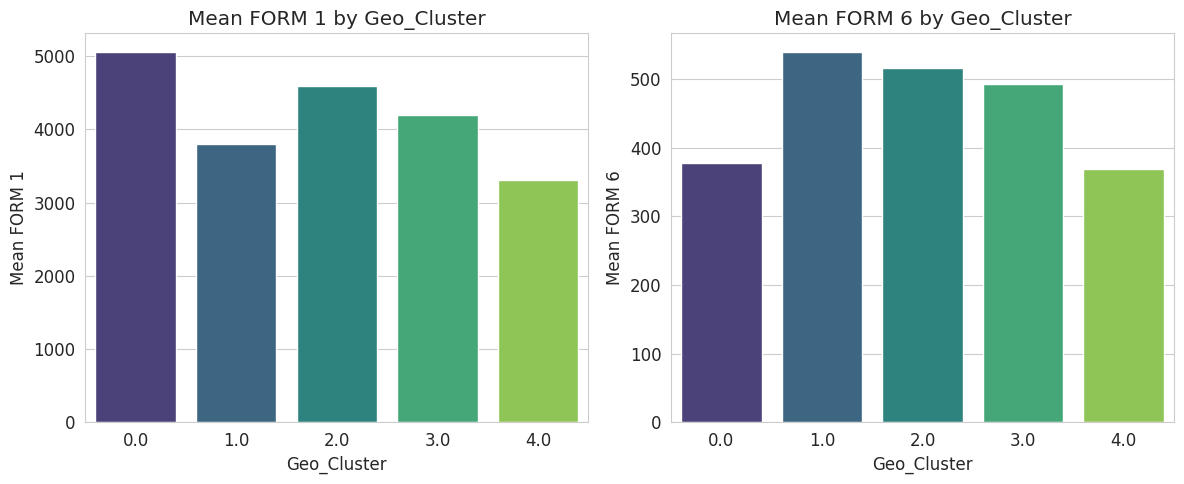


Visualizing mean metrics for Combined_Secondary_Electricity_Govt:


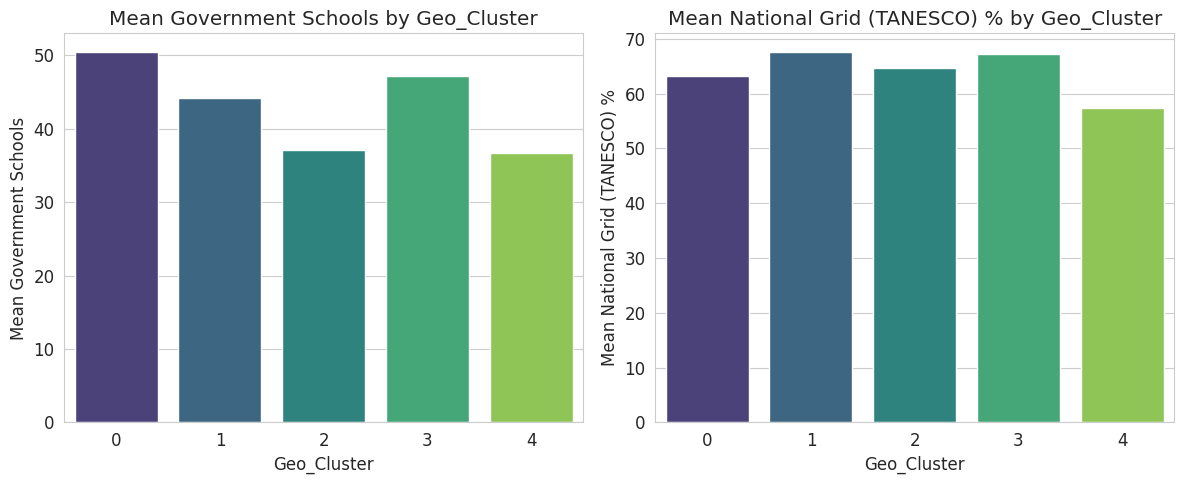


Visualizing distributions (box plots) for selected metrics:


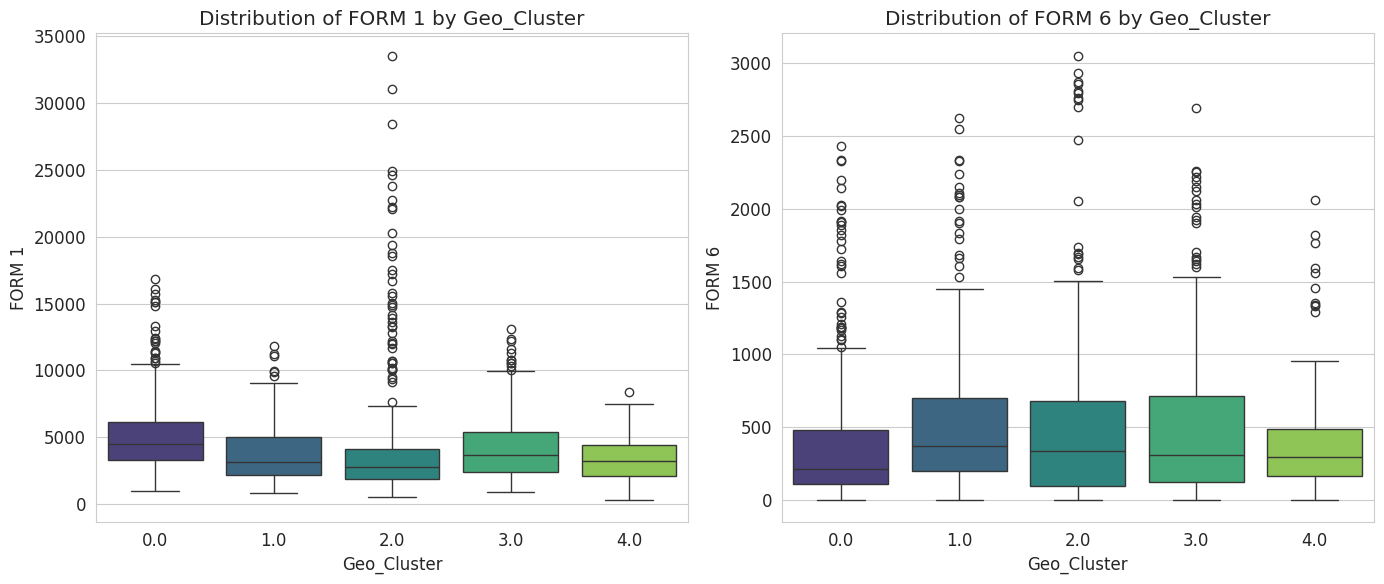

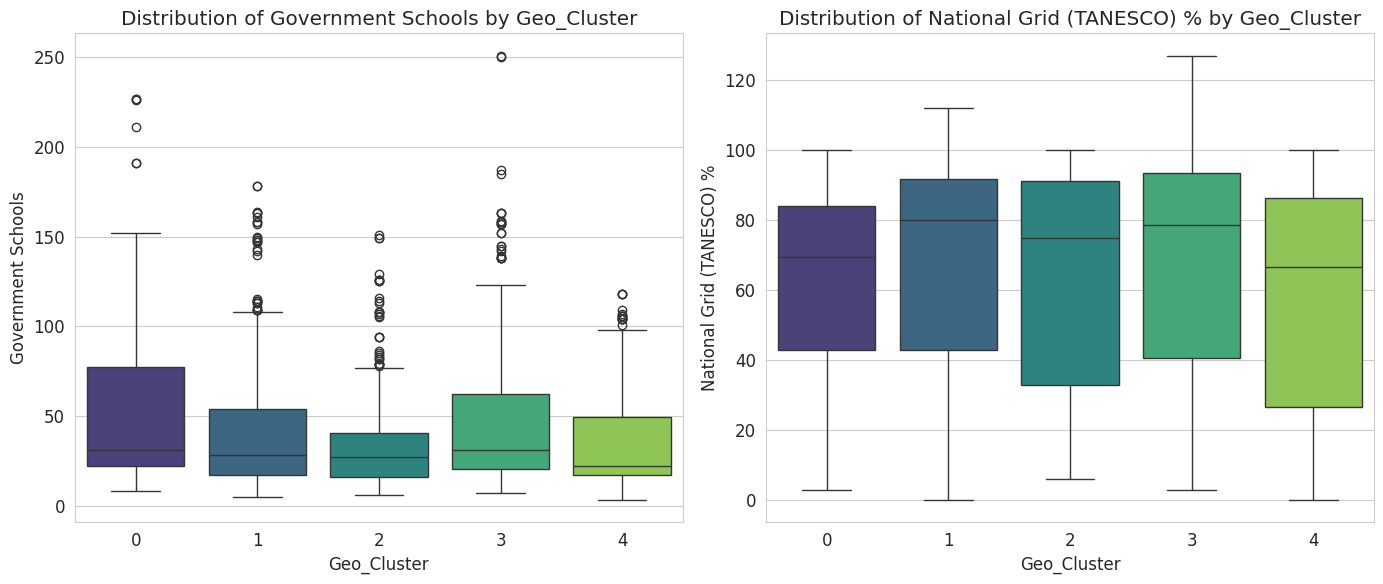

--- All visualizations generated. ---


In [ ]:
print("--- Generating Visualizations for Cluster Characteristics ---")

# Set plotting style
sns.set_style("whitegrid")

# Bar plots for mean values from cluster_analysis_results
for df_name, stats_df in cluster_analysis_results.items():
    print(f"\nVisualizing mean metrics for {df_name}:")

    # Get all metric columns from the grouped_stats DataFrame
    # Flatten MultiIndex columns if they exist (mean, median, std)
    if isinstance(stats_df.columns, pd.MultiIndex):
        metrics_to_plot = stats_df.columns.levels[0].tolist()
        # Ensure 'Geo_Cluster' is not treated as a metric if it was somehow included
        if 'Geo_Cluster' in metrics_to_plot:
            metrics_to_plot.remove('Geo_Cluster')
    else:
        metrics_to_plot = stats_df.columns.tolist()

    # Create a figure for each DataFrame to hold multiple bar plots
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0: # Ensure there are metrics to plot
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 6, 5), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten in case n_metrics > 1 to iterate easily

    for i, metric in enumerate(metrics_to_plot):
        # Extract mean values for the current metric
        if isinstance(stats_df.columns, pd.MultiIndex):
            plot_data = stats_df[metric]['mean']
        else:
            plot_data = stats_df[metric]

        sns.barplot(x=plot_data.index, y=plot_data.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Mean {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(f'Mean {metric}')

    plt.tight_layout()
    plt.show()

# Box plots for distribution from original DataFrames
print("\nVisualizing distributions (box plots) for selected metrics:")
for df_name, metrics in dfs_to_analyze.items():
    df = loaded_dataframes[df_name]

    if 'Geo_Cluster' not in df.columns:
        continue

    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        continue

    n_metrics = len(valid_metrics)
    if n_metrics == 0:
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 7, 6), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten for consistency

    for i, metric in enumerate(valid_metrics):
        sns.boxplot(x='Geo_Cluster', y=metric, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(metric)

    plt.tight_layout()
    plt.show()

print("--- All visualizations generated. ---")

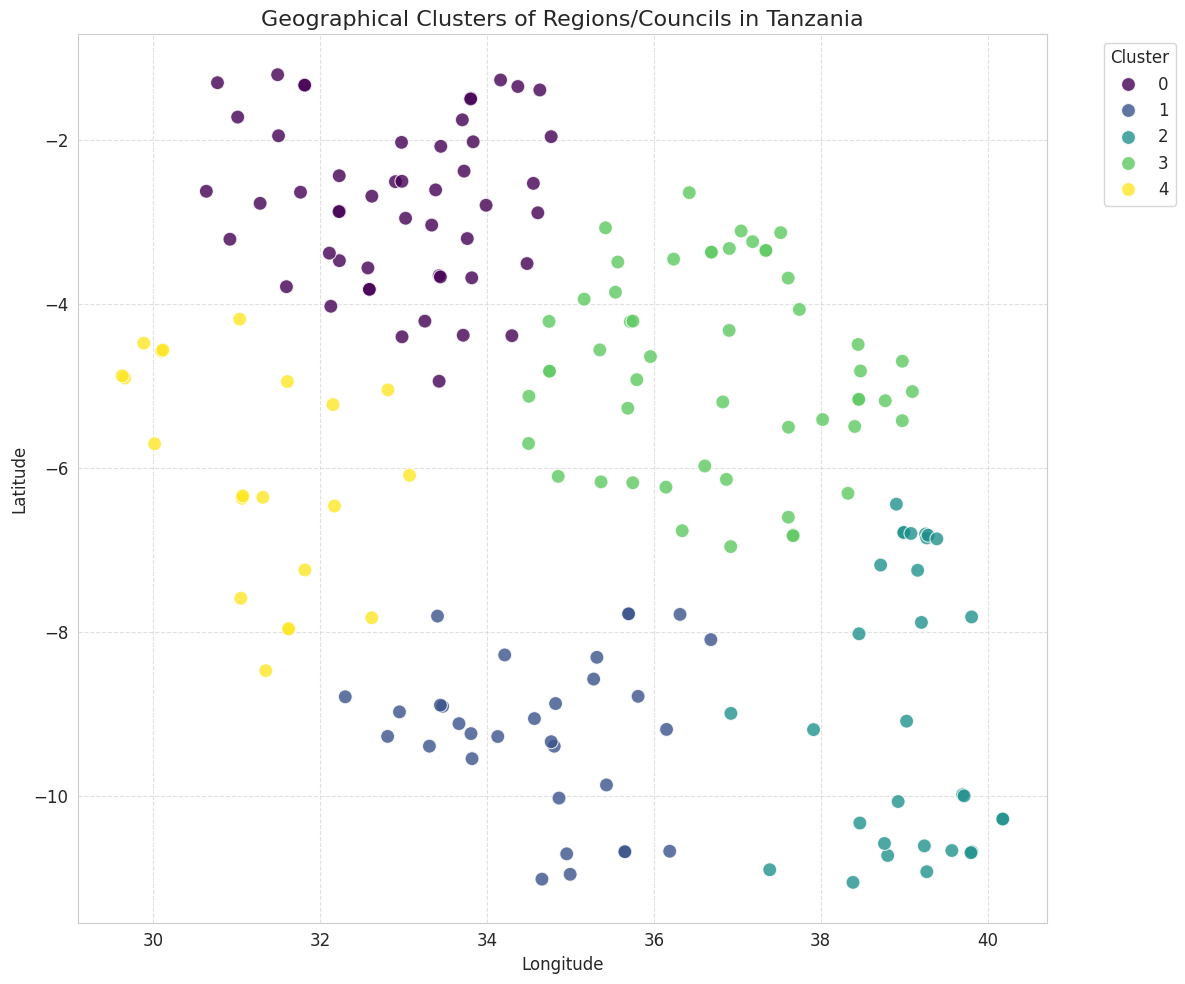

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Latitude and Longitude are numeric and handle any remaining nulls, though it should be clean from previous steps
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=geo_data,
    x='Longitude',
    y='Latitude',
    hue='Geo_Cluster',
    palette='viridis',
    s=100, # Adjust point size for better visibility
    alpha=0.8
)

plt.title('Geographical Clusters of Regions/Councils in Tanzania', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# 1. SETUP MAP
# Centered on Tanzania
tanzania_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6)
marker_cluster = MarkerCluster().add_to(tanzania_map)

# 2. ADD POINTS
# Assuming 'geo_data_final' is your dataframe with Lat/Lon
for idx, row in geo_data_final.dropna(subset=['Latitude', 'Longitude']).iterrows():
    popup_text = f"{row['Region']} - {row['Council']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=row['Council']
    ).add_to(marker_cluster)

# 3. DISPLAY IN NOTEBOOK
tanzania_map

In [ ]:
import numpy as np

# 1. Initialize an empty dictionary
numerical_cols_for_outlier_treatment = {}

# 2. Define a list of columns to exclude from outlier treatment
exclude_cols = ['Year', 'YEAR', 'Academic Year', 'Latitude', 'Longitude', 'Geo_Cluster', 'Geo_Cluster_geo']

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Get a list of all numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 5. Filter this list to exclude any column whose name is present in the exclude_cols list
    relevant_numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    # 6. Store the filtered list in the dictionary
    numerical_cols_for_outlier_treatment[df_name] = relevant_numerical_cols

# 7. Print the identified columns
print("Numerical columns identified for outlier treatment:")
for df_name, cols in numerical_cols_for_outlier_treatment.items():
    print(f"  {df_name}: {cols}")

Numerical columns identified for outlier treatment:
  Data-Secondary Enrollment 2016-2025: ['FORM 1', 'FORM 2', 'FORM 3', 'FORM 4', 'FORM 5', 'FORM 6']
  Dropout-Secondary  2017-2024: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']
  Data-Secondary Tables and chairs 2016-2025: ['Enrollment', 'Available_tables', 'Available_chairs']
  Secondary-Re_entry: ['Re-Enrolled Students, Form 1 Boys', 'Re-Enrolled Students, Form 1 Girls', 'Re-Enrolled Students, Form 2 Boys', 'Re-Enrolled Students, Form 2 Girls', 'Re-Enrolled Students, Form 3 Boys', 'Re-Enrolled Students, Form 3 Girls', 'Re-Enrolled Students, Form 4 Boys', 'Re-Enrolled Students, Form 4 Girls', 'Re-Enrolled Students, Form 5 Boys', 'Re-Enrolled Students, Form 5 Girls', 'Re-Enrolled Students, Form 6 Boys', 'Re-Enrolled Students, Form 6 Girls']
  Secondary - DISABALITY 2020-2025: ['Blind', 'Low Vision']
  Combined_Secondary_ICT_All_G_NG: ['Total Enrolment', 'Deck/DVD', 'Desktop Computers', 'Laptop Computers', 'Photocopier', 'Printer'

In [ ]:
import pandas as pd

print("--- Listing all DataFrames with columns and data types ---")

for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    df.info()

--- Listing all DataFrames with columns and data types ---

--- DataFrame: Data-Secondary Enrollment 2016-2025 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         1836 non-null   int64  
 1   Region       1836 non-null   object 
 2   Council      1836 non-null   object 
 3   FORM 1       1836 non-null   int64  
 4   FORM 2       1836 non-null   int64  
 5   FORM 3       1836 non-null   int64  
 6   FORM 4       1836 non-null   int64  
 7   FORM 5       1836 non-null   int64  
 8   FORM 6       1836 non-null   int64  
 9   LGA_Status   1766 non-null   object 
 10  Geo_Cluster  1766 non-null   float64
dtypes: float64(1), int64(7), object(3)
memory usage: 157.9+ KB

--- DataFrame: Dropout-Secondary  2017-2024 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 11 columns):
 #   Column 

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. Data Cleaning & Standardization
# ==========================================
def standard_cols(df):
    """Standardizes column names to Upper Case and strips whitespace."""
    df = df.copy()
    df.columns = [str(c).strip().upper() for c in df.columns]

    # Standardize common location columns
    rename_map = {
        'YEAR': 'YEAR', 'REGION': 'REGION', 'COUNCIL': 'COUNCIL',
        'LGA_STATUS': 'LGA_STATUS', 'GEO_CLUSTER': 'GEO_CLUSTER'
    }
    df.rename(columns=rename_map, inplace=True)

    # Drop duplicates if any column names repeated
    df = df.loc[:, ~df.columns.duplicated()]
    return df

def prepare_secondary_datasets(df_enroll, df_drop, df_table, df_reentry, df_disability, df_ict, df_elec, df_labs):
    """
    Cleans and prepares all secondary school datasets.
    """
    enroll = standard_cols(df_enroll)
    drops = standard_cols(df_drop)
    tables = standard_cols(df_table)
    reentry = standard_cols(df_reentry)
    disability = standard_cols(df_disability)
    ict = standard_cols(df_ict)
    elec = standard_cols(df_elec)
    labs = standard_cols(df_labs)

    # --- 1. Reshape Enrollment (Wide to Long) ---
    form_cols = [c for c in enroll.columns if 'FORM ' in c]
    id_vars = ['YEAR', 'REGION', 'COUNCIL', 'LGA_STATUS', 'GEO_CLUSTER']
    available_ids = [c for c in id_vars if c in enroll.columns]

    enroll_long = enroll.melt(id_vars=available_ids,
                              value_vars=form_cols,
                              var_name='FORM',
                              value_name='ENROLLMENT')

    # Map Forms to Numbers for Cohort Logic
    form_map = {
        'FORM 1': 1, 'FORM 2': 2, 'FORM 3': 3,
        'FORM 4': 4, 'FORM 5': 5, 'FORM 6': 6
    }
    enroll_long['FORM_NUM'] = enroll_long['FORM'].map(form_map)

    # --- 2. Aggregations for Feature Sets ---
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # Re-entry: Sum all re-enrolled students per Council/Year
    re_cols = [c for c in reentry.columns if 'RE-ENROLLED' in c]
    if re_cols:
        reentry['TOTAL_REENTRY'] = reentry[re_cols].sum(axis=1)
        reentry_clean = reentry[keys + ['TOTAL_REENTRY']].groupby(keys).sum().reset_index()
    else:
        reentry_clean = pd.DataFrame(columns=keys + ['TOTAL_REENTRY'])

    # Disability: Sum all disabled students
    dis_cols = ['BLIND', 'LOW VISION']
    avail_dis = [c for c in dis_cols if c in disability.columns]
    if avail_dis:
        disability['TOTAL_DISABLED'] = disability[avail_dis].sum(axis=1)
        dis_clean = disability[keys + ['TOTAL_DISABLED']].groupby(keys).sum().reset_index()
    else:
        dis_clean = pd.DataFrame(columns=keys + ['TOTAL_DISABLED'])

    # Infrastructure: Select critical columns
    # Tables
    if 'AVAILABLE_TABLES' in tables.columns:
        tables_clean = tables[keys + ['AVAILABLE_TABLES']].copy()
    else:
        tables_clean = pd.DataFrame(columns=keys + ['AVAILABLE_TABLES'])

    # ICT (Computers)
    if 'DESKTOP COMPUTERS' in ict.columns and 'LAPTOP COMPUTERS' in ict.columns:
        ict['TOTAL_COMPUTERS'] = ict['DESKTOP COMPUTERS'].fillna(0) + ict['LAPTOP COMPUTERS'].fillna(0)
        ict_clean = ict[keys + ['TOTAL_COMPUTERS']].copy()
    else:
        ict_clean = pd.DataFrame(columns=keys + ['TOTAL_COMPUTERS'])

    # Electricity (% Grid)
    elec_col = 'NATIONAL GRID (TANESCO) %'
    if elec_col in elec.columns:
        elec_clean = elec[keys + [elec_col]].copy()
        elec_clean.rename(columns={elec_col: 'ELEC_GRID_PCT'}, inplace=True)
    else:
        elec_clean = pd.DataFrame(columns=keys + ['ELEC_GRID_PCT'])

    # Labs (Total Available)
    lab_types = ['BIOLOGY', 'CHEMISTRY', 'PHYSICS']
    lab_cols = [f'{l} LABORATORY AVAILABLE' for l in lab_types]
    valid_labs = [c for c in lab_cols if c in labs.columns]
    if valid_labs:
        labs['TOTAL_LABS'] = labs[valid_labs].sum(axis=1)
        labs_clean = labs[keys + ['TOTAL_LABS']].copy()
    else:
        labs_clean = pd.DataFrame(columns=keys + ['TOTAL_LABS'])

    return enroll_long, drops, tables_clean, reentry_clean, dis_clean, ict_clean, elec_clean, labs_clean

# ==========================================
# 2. Feature Engineering
# ==========================================
def engineer_secondary_features(df, drops, tables, reentry, disability, ict, elec, labs):
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # --- Merge Infrastructure & Social Features ---
    # Merge Left to keep all enrollment rows, fill missing infra with 0 (or median in production)
    df = df.merge(tables, on=keys, how='left').fillna({'AVAILABLE_TABLES': 0})
    df = df.merge(reentry, on=keys, how='left').fillna({'TOTAL_REENTRY': 0})
    df = df.merge(disability, on=keys, how='left').fillna({'TOTAL_DISABLED': 0})
    df = df.merge(ict, on=keys, how='left').fillna({'TOTAL_COMPUTERS': 0})
    df = df.merge(elec, on=keys, how='left').fillna({'ELEC_GRID_PCT': 0})
    df = df.merge(labs, on=keys, how='left').fillna({'TOTAL_LABS': 0})

    # Dropouts (Sum specific causes)
    drop_cols = ['TRUANCY', 'PREGNANCY', 'INDISCIPLINE']
    valid_drops = [c for c in drop_cols if c in drops.columns]
    if valid_drops:
        d_grp = drops.groupby(keys)[valid_drops].sum().reset_index()
        df = df.merge(d_grp, on=keys, how='left').fillna(0)

    # Sort for Time Series Ops
    df = df.sort_values(['REGION', 'COUNCIL', 'FORM_NUM', 'YEAR'])

    # --- Temporal Features ---
    df['IS_ELECTION_YEAR'] = df['YEAR'].apply(lambda x: 1 if x in [2015, 2020, 2025] else 0)

    # --- Lags & Trends ---
    # Group by Region/Council/Form (How did Form 1 grow over years?)
    g = df.groupby(['REGION', 'COUNCIL', 'FORM'])
    df['LAG_1'] = g['ENROLLMENT'].shift(1)
    df['LAG_2'] = g['ENROLLMENT'].shift(2)
    df['YOY_GROWTH'] = (df['ENROLLMENT'] - df['LAG_1']) / (df['LAG_1'] + 1e-5)

    # --- Cohort Logic (The "Diagonal" Flow) ---
    # We want to link Form 1 (2020) -> Form 2 (2021)
    # 1. Create a Join Key for the *Previous* Year/Form

    df['PREV_YEAR'] = df['YEAR'] - 1
    df['PREV_FORM_NUM'] = df['FORM_NUM'] - 1

    # Create lookup dictionary from the dataframe itself
    # Key: "YEAR_REGION_COUNCIL_FORM" -> Value: Enrollment
    df['LOOKUP_KEY'] = (
        df['YEAR'].astype(str) + '_' +
        df['REGION'] + '_' +
        df['COUNCIL'] + '_' +
        df['FORM_NUM'].astype(str)
    )
    enrollment_lookup = df.set_index('LOOKUP_KEY')['ENROLLMENT'].to_dict()

    # 2. Generate the Key to look for
    df['COHORT_LOOKUP_KEY'] = (
        df['PREV_YEAR'].astype(str) + '_' +
        df['REGION'] + '_' +
        df['COUNCIL'] + '_' +
        df['PREV_FORM_NUM'].astype(str)
    )

    # 3. Map values
    df['COHORT_LAG'] = df['COHORT_LOOKUP_KEY'].map(enrollment_lookup)

    # 4. Handle Entry Points (Form 1 and Form 5)
    # Form 1 has no history in Secondary. Form 5 is selected from Form 4 (exams).
    # We fill NA with -1 to let trees handle the "missingness" as a signal.
    df['COHORT_LAG'] = df['COHORT_LAG'].fillna(-1)

    # Cleanup aux columns
    df.drop(columns=['PREV_YEAR', 'PREV_FORM_NUM', 'LOOKUP_KEY', 'COHORT_LOOKUP_KEY'], inplace=True)
    df = df.fillna(-1) # Fill remaining NaNs for models

    return df

# ==========================================
# 3. Model Training & EVALUATION (UPDATED with R^2)
# ==========================================
def calculate_metrics(y_true, y_pred, model_name):
    """Calculates MAE, RMSE, R2, and MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred) # <--- ADDED R-SQUARED

    # Handling MAPE division by zero
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    print(f"--- {model_name} Results ---")
    print(f"MAE  : {mae:,.2f} (Average miss in students)")
    print(f"RMSE : {rmse:,.2f} (Penalty for large outliers)")
    print(f"R^2  : {r2:.4f} (Variance explained)")
    print(f"MAPE : {mape:.2f}% (Percentage Error)")
    print("-" * 30)

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def train_secondary_models(df):
    le = LabelEncoder()
    df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))

    features = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Filter only features that exist after cleaning
    features = [f for f in features if f in df.columns]

    train = df[df['YEAR'] < 2024]
    test = df[df['YEAR'] >= 2024]

    X_train, y_train = train[features], train['ENROLLMENT']
    X_test, y_test = test[features], test['ENROLLMENT']

    print(f"Training on {X_train.shape[0]} rows, Testing on {X_test.shape[0]} rows.")

    results = {}

    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=7, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    results['XGB'] = calculate_metrics(y_test, xgb_model.predict(X_test), "XGBoost")

    # LightGBM
    lgb_model = lgb.LGBMRegressor(n_estimators=150, num_leaves=40, verbose=-1)
    lgb_model.fit(X_train, y_train)
    results['LGBM'] = calculate_metrics(y_test, lgb_model.predict(X_test), "LightGBM")

    return results, xgb_model

# ==========================================
# 4. Pipeline Execution
# ==========================================
def run_secondary_pipeline(enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df):
    print("1. Preparing Datasets...")
    enroll, drops, tables, reentry, dis, ict, elec, labs = prepare_secondary_datasets(
        enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df
    )

    print("2. Engineering Features (Cohorts, Labs, ICT)...")
    final_df = engineer_secondary_features(enroll, drops, tables, reentry, dis, ict, elec, labs)

    print("\n==========================================")
    print(" SECONDARY SCHOOL ENROLLMENT FORECASTING ")
    print("==========================================")
    metrics, model = train_secondary_models(final_df)

    return final_df, metrics, model

# EXECUTION WITH YOUR DATAFRAMES
secondary_final_df, sec_metrics, sec_model = run_secondary_pipeline(
    loaded_dataframes["Data-Secondary Enrollment 2016-2025"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

1. Preparing Datasets...
2. Engineering Features (Cohorts, Labs, ICT)...

 SECONDARY SCHOOL ENROLLMENT FORECASTING 
Training on 8808 rows, Testing on 2208 rows.
--- XGBoost Results ---
MAE  : 104.24 (Average miss in students)
RMSE : 353.65 (Penalty for large outliers)
R^2  : 0.9876 (Variance explained)
MAPE : 7.99% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 110.92 (Average miss in students)
RMSE : 439.63 (Penalty for large outliers)
R^2  : 0.9809 (Variance explained)
MAPE : 6.26% (Percentage Error)
------------------------------


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. Feature Generation Helper (Secondary Specific)
# ==========================================
def create_next_year_secondary_features(last_year_df, current_year):
    """
    Generates features for Year T based on Year T-1 data for SECONDARY SCHOOLS.
    Handles Form 1-6 logic and Infrastructure carry-over.
    """
    next_df = last_year_df.copy()

    # Update Year
    next_df['YEAR'] = current_year

    # 1. Shift Lags (The recursive step)
    # New Lag_2 is the old Lag_1
    next_df['LAG_2'] = next_df['LAG_1']
    # New Lag_1 is the old Enrollment (Actual or Predicted)
    next_df['LAG_1'] = next_df['ENROLLMENT']

    # 2. Update YOY Growth (Estimated based on recent trend)
    # We cap growth to avoid explosions in recursive loops
    next_df['YOY_GROWTH'] = (next_df['LAG_1'] - next_df['LAG_2']) / (next_df['LAG_2'] + 1e-5)

    # 3. Update Cohort Lag (The "Flow" Model)
    # Form F in Year T needs Form F-1 from Year T-1

    # Create a dictionary: {(Region, Council, Form_Num): Enrollment} from T-1
    cohort_lookup = last_year_df.set_index(['REGION', 'COUNCIL', 'FORM_NUM'])['ENROLLMENT'].to_dict()

    def get_cohort_val(row):
        target_form = row['FORM_NUM'] - 1

        # If target form is 0 (i.e., we are at Form 1), we have no history in this dataset
        if target_form < 1:
            return -1

        key = (row['REGION'], row['COUNCIL'], target_form)
        return cohort_lookup.get(key, -1)

    next_df['COHORT_LAG'] = next_df.apply(get_cohort_val, axis=1)

    # 4. Update Time-Sensitive Features
    # Election years in TZ: 2025, 2030
    next_df['IS_ELECTION_YEAR'] = 1 if current_year in [2025, 2030] else 0

    # 5. Infrastructure & Social Features (Assumption: Last Observation Carried Forward)
    # We assume Labs, Tables, and Electricity don't disappear, but don't automatically grow without a plan.
    # They stay constant from the previous year.

    # 6. Reset Enrollment (Target) to NaN
    next_df['ENROLLMENT'] = np.nan

    return next_df

# ==========================================
# 2. Forecasting Engine
# ==========================================
def generate_secondary_forecasts(final_df, models):
    """
    Loops from 2026 to 2030, predicting one year at a time and updating features.
    """
    print(f"Starting Recursive Forecast (2026-2030)...")

    future_predictions = []

    # Start with the last known data (2025)
    last_known = final_df[final_df['YEAR'] == final_df['YEAR'].max()].copy()
    current_sim = last_known.copy()

    # Define features (Must match training exactly)
    feats = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Ensure all feats exist
    feats = [f for f in feats if f in current_sim.columns]

    model_xgb = models['XGB']
    model_lgb = models['LGBM']

    for year in range(2026, 2031):
        # 1. Create features for this future year
        next_step = create_next_year_secondary_features(current_sim, year)

        # 2. Predict
        X = next_step[feats]

        # Ensemble Prediction
        pred_xgb = model_xgb.predict(X)
        pred_lgb = model_lgb.predict(X)

        # Average
        next_step['ENROLLMENT'] = (pred_xgb + pred_lgb) / 2

        # Safety: No negative students
        next_step['ENROLLMENT'] = next_step['ENROLLMENT'].apply(lambda x: max(0, x))

        # 3. Save
        next_step['TYPE'] = 'Secondary'
        future_predictions.append(next_step)

        # 4. Update current_sim so the NEXT loop uses these predictions as history
        current_sim = next_step.copy()

        print(f" > Year {year} forecasted.")

    # Combine all years
    forecast_df = pd.concat(future_predictions, ignore_index=True)
    return forecast_df

# ==========================================
# 3. Main Execution Wrapper
# ==========================================
def run_secondary_prediction_pipeline(df):

    print("\n==========================================")
    print(" RETRAINING MODELS ON FULL HISTORY (2016-2025) ")
    print("==========================================")

    # 1. Encode Region/Council for the whole dataset
    le_region = LabelEncoder()
    le_council = LabelEncoder()

    df['REGION_ENC'] = le_region.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le_council.fit_transform(df['COUNCIL'].astype(str))

    # 2. Define Features
    feats = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Filter valid columns
    feats = [c for c in feats if c in df.columns]

    X = df[feats]
    y = df['ENROLLMENT']

    # 3. Train Full Models (No Test Split - We want max knowledge)
    print(" > Training XGBoost...")
    xgb_m = xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05)
    xgb_m.fit(X, y)

    print(" > Training LightGBM...")
    lgb_m = lgb.LGBMRegressor(n_estimators=200, num_leaves=50, verbose=-1)
    lgb_m.fit(X, y)

    models_full = {'XGB': xgb_m, 'LGBM': lgb_m}

    # 4. Generate Forecasts
    forecast_df = generate_secondary_forecasts(df, models_full)

    # 5. Format Output
    output = forecast_df[['YEAR', 'REGION', 'COUNCIL', 'FORM', 'ENROLLMENT']].copy()
    output['ENROLLMENT'] = output['ENROLLMENT'].round(0).astype(int)

    print("\nPrediction Complete!")
    return output

# ==========================================
# MASTER EXECUTION BLOCK
# ==========================================

# 1. Run the Cleaning/Engineering Pipeline (From previous step) to get 'secondary_final_df'
print("STEP 1: Preparing Data...")
# Note: We reuse the functions defined in your previous request
secondary_final_df, _, _ = run_secondary_pipeline(
    loaded_dataframes["Data-Secondary Enrollment 2016-2025"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 2. Run the Forecasting Pipeline
print("\nSTEP 2: Forecasting 2026-2030...")
future_secondary_enrollment = run_secondary_prediction_pipeline(secondary_final_df)

# 3. View Results
print("\n--- Forecast Sample (First 5 Rows) ---")
print(future_secondary_enrollment.head())

# Optional: Export
# future_secondary_enrollment.to_csv("Secondary_School_Forecast_2026_2030.csv", index=False)

STEP 1: Preparing Data...
1. Preparing Datasets...
2. Engineering Features (Cohorts, Labs, ICT)...

 SECONDARY SCHOOL ENROLLMENT FORECASTING 
Training on 8808 rows, Testing on 2208 rows.
--- XGBoost Results ---
MAE  : 104.24 (Average miss in students)
RMSE : 353.65 (Penalty for large outliers)
R^2  : 0.9876 (Variance explained)
MAPE : 7.99% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 110.92 (Average miss in students)
RMSE : 439.63 (Penalty for large outliers)
R^2  : 0.9809 (Variance explained)
MAPE : 6.26% (Percentage Error)
------------------------------

STEP 2: Forecasting 2026-2030...

 RETRAINING MODELS ON FULL HISTORY (2016-2025) 
 > Training XGBoost...
 > Training LightGBM...
Starting Recursive Forecast (2026-2030)...
 > Year 2026 forecasted.
 > Year 2027 forecasted.
 > Year 2028 forecasted.
 > Year 2029 forecasted.
 > Year 2030 forecasted.

Prediction Complete!

--- Forecast Sample (First 5 Rows) ---
   YEAR  REGION COUNCIL    FORM  ENROLLM

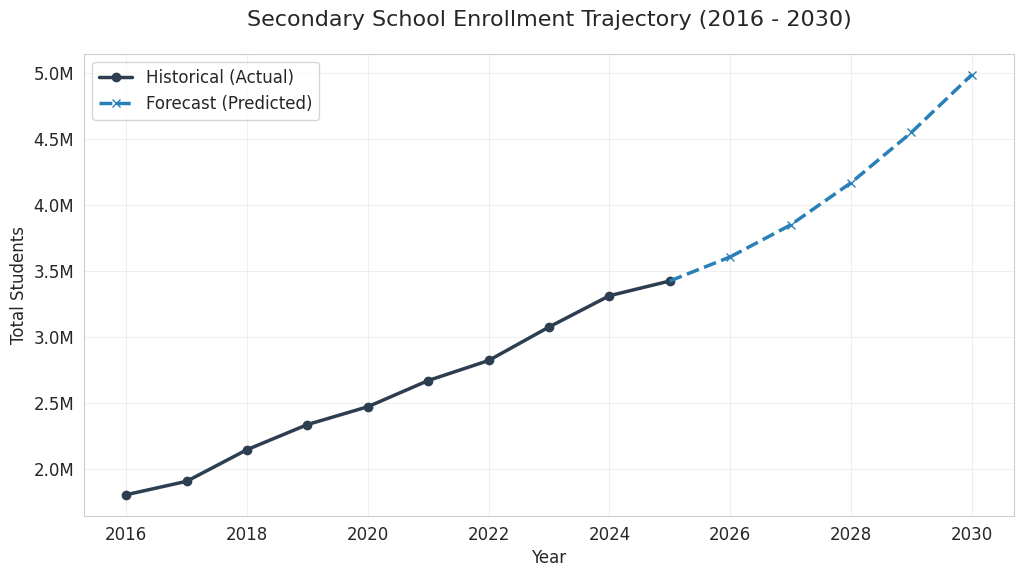

<Figure size 1400x700 with 0 Axes>

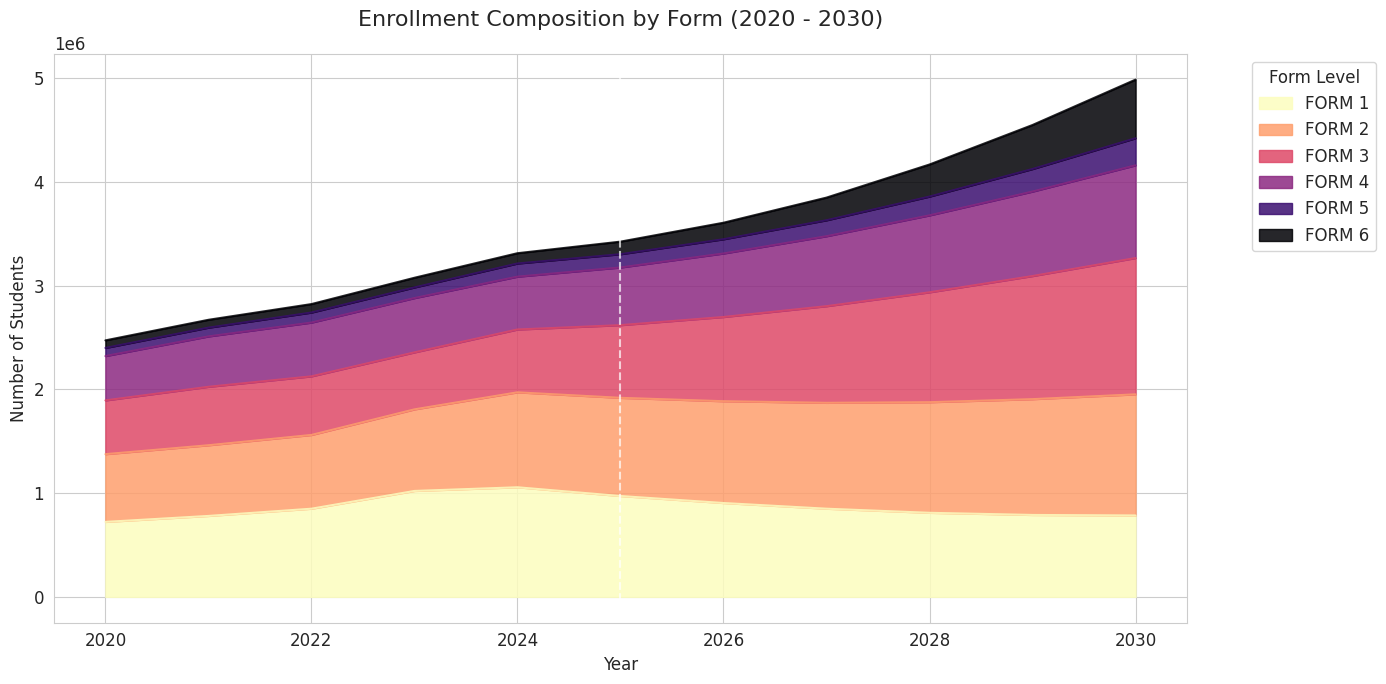

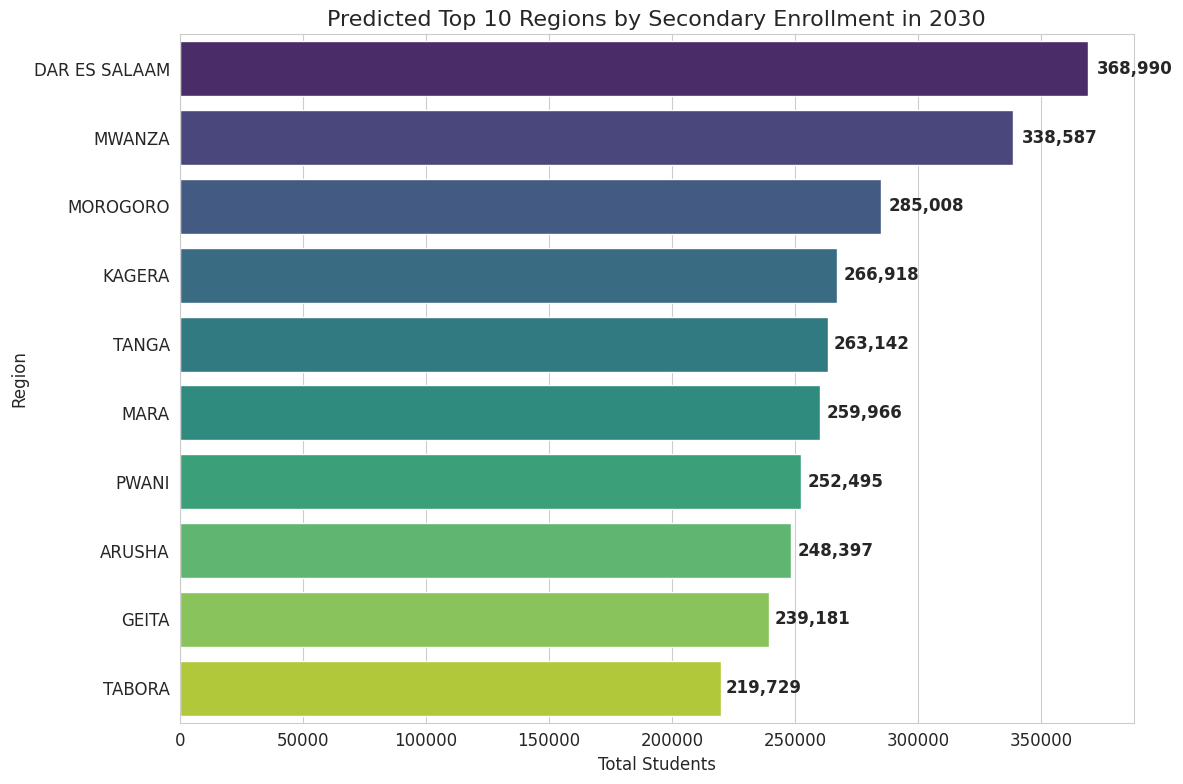

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_secondary_forecasts(history_df, forecast_df):
    """
    Plots historical vs. forecasted trends specifically for Secondary Schools (Form 1-6).
    Args:
        history_df: DataFrame of historical Secondary data (2016-2025)
        forecast_df: DataFrame of forecasted data (2026-2030)
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # --- 1. PREPARE DATA ---
    # Combine history (using 'FORM' column)
    hist_clean = history_df[['YEAR', 'ENROLLMENT', 'FORM', 'REGION']].copy()
    hist_clean['Type'] = 'Historical'

    # Prepare forecast (using 'FORM' column)
    forc_clean = forecast_df[['YEAR', 'ENROLLMENT', 'FORM', 'REGION']].copy()
    forc_clean['Type'] = 'Forecast'

    # Merge for plotting
    full_data = pd.concat([hist_clean, forc_clean])

    # --- CHART 1: Total National Secondary Enrollment (Trajectory) ---
    plt.figure(figsize=(12, 6))

    # Aggregation
    total_trend = full_data.groupby(['YEAR', 'Type'])['ENROLLMENT'].sum().reset_index()

    # Plot History
    hist_trend = total_trend[total_trend['Type'] == 'Historical']
    plt.plot(hist_trend['YEAR'], hist_trend['ENROLLMENT'],
             label='Historical (Actual)', color='#2c3e50', linewidth=2.5, marker='o')

    # Plot Forecast
    forc_trend = total_trend[total_trend['Type'] == 'Forecast']
    plt.plot(forc_trend['YEAR'], forc_trend['ENROLLMENT'],
             label='Forecast (Predicted)', color='#2980b9', linewidth=2.5, linestyle='--', marker='x')

    # Connect the gap (Year 2025 -> 2026)
    if not hist_trend.empty and not forc_trend.empty:
        connect_x = [hist_trend['YEAR'].max(), forc_trend['YEAR'].min()]
        connect_y = [hist_trend['ENROLLMENT'].iloc[-1], forc_trend['ENROLLMENT'].iloc[0]]
        plt.plot(connect_x, connect_y, color='#2980b9', linestyle='--', linewidth=2.5)

    plt.title('Secondary School Enrollment Trajectory (2016 - 2030)', fontsize=16, pad=20)
    plt.ylabel('Total Students', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format Y-axis to Millions
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])
    plt.show()

    # --- CHART 2: Enrollment by Form Level (Stacked Area) ---
    plt.figure(figsize=(14, 7))

    # Pivot for Stacked Plot
    # Ensure correct logical order for secondary school
    form_order = ['FORM 1', 'FORM 2', 'FORM 3', 'FORM 4', 'FORM 5', 'FORM 6']

    # Map any "FORM-1" naming variations if they exist, otherwise assume standard "FORM 1"
    # (The previous pipeline standardised to "FORM 1", "FORM 2" etc.)

    # Filter: Plot transition from 2020 to 2030 to see the "Covid Cohort" or "Free Ed" cohort move
    recent_data = full_data[full_data['YEAR'] >= 2020].copy()

    # Pivot
    pivot_df = recent_data.groupby(['YEAR', 'FORM'])['ENROLLMENT'].sum().unstack()

    # Reindex to ensure strict Form 1 -> Form 6 order (handling missing columns gracefully)
    existing_cols = [c for c in form_order if c in pivot_df.columns]
    pivot_df = pivot_df[existing_cols]

    # Plot
    pivot_df.plot.area(stacked=True, alpha=0.85, figsize=(14, 7), cmap='magma_r')
    # 'magma_r' is good for intensity (Dark = Form 6, Light = Form 1 or vice versa)

    plt.title('Enrollment Composition by Form (2020 - 2030)', fontsize=16, pad=20)
    plt.ylabel('Number of Students', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Form Level")

    # Add vertical line for "Today"
    plt.axvline(x=2025, color='white', linestyle='--', alpha=0.7, label='Forecast Start')
    plt.tight_layout()
    plt.show()

    # --- CHART 3: Top 10 Regions in 2030 (Bar Chart) ---
    plt.figure(figsize=(12, 8))

    data_2030 = forecast_df[forecast_df['YEAR'] == 2030]

    if not data_2030.empty:
        top_regions = data_2030.groupby('REGION')['ENROLLMENT'].sum().sort_values(ascending=False).head(10)

        sns.barplot(x=top_regions.values, y=top_regions.index, palette='viridis')

        plt.title('Predicted Top 10 Regions by Secondary Enrollment in 2030', fontsize=16)
        plt.xlabel('Total Students', fontsize=12)
        plt.ylabel('Region', fontsize=12)

        # Add value labels
        for i, v in enumerate(top_regions.values):
            plt.text(v + (v*0.01), i, f'{v:,.0f}', va='center', fontweight='bold')
    else:
        print("No data available for 2030 to plot regional chart.")

    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
# Run this using the variables from the Secondary pipeline:
# 1. secondary_final_df (The historical data prepared in Step 1)
# 2. future_secondary_enrollment (The forecast data from Step 2)

plot_secondary_forecasts(secondary_final_df, future_secondary_enrollment)

STEP 1: Training Models on 2016-2025 Data...
1. Preparing Datasets...
2. Engineering Features (Cohorts, Labs, ICT)...

 SECONDARY SCHOOL ENROLLMENT FORECASTING 
Training on 8808 rows, Testing on 2208 rows.
--- XGBoost Results ---
MAE  : 104.24 (Average miss in students)
RMSE : 353.65 (Penalty for large outliers)
R^2  : 0.9876 (Variance explained)
MAPE : 7.99% (Percentage Error)
------------------------------
--- LightGBM Results ---
MAE  : 110.92 (Average miss in students)
RMSE : 439.63 (Penalty for large outliers)
R^2  : 0.9809 (Variance explained)
MAPE : 6.26% (Percentage Error)
------------------------------

STEP 2: Generating Recursive Forecasts (Forms 1-6)...

 RETRAINING MODELS ON FULL HISTORY (2016-2025) 
 > Training XGBoost...
 > Training LightGBM...
Starting Recursive Forecast (2026-2030)...
 > Year 2026 forecasted.
 > Year 2027 forecasted.
 > Year 2028 forecasted.
 > Year 2029 forecasted.
 > Year 2030 forecasted.

Prediction Complete!

STEP 3: Preview of Forecast Data (First

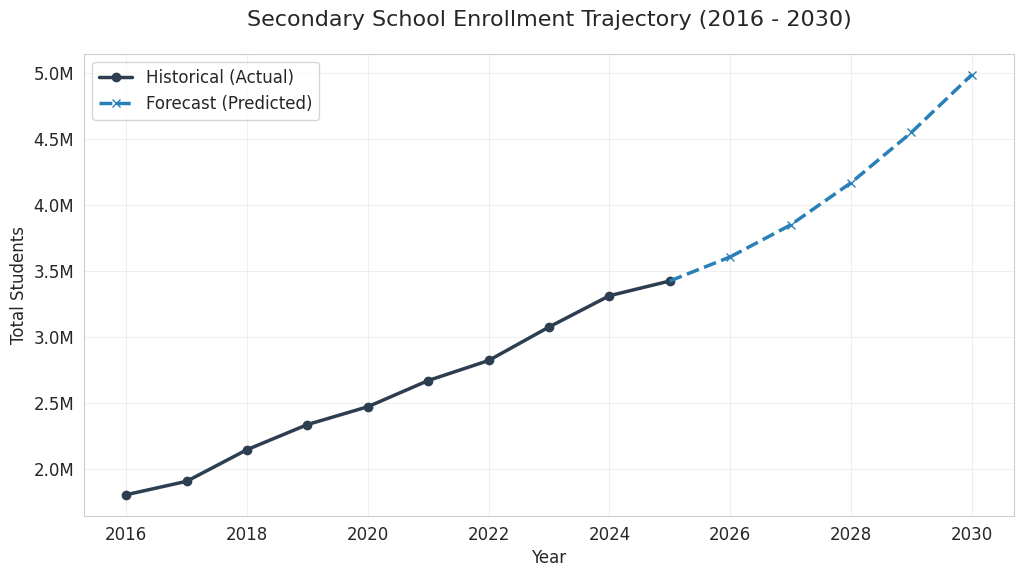

<Figure size 1400x700 with 0 Axes>

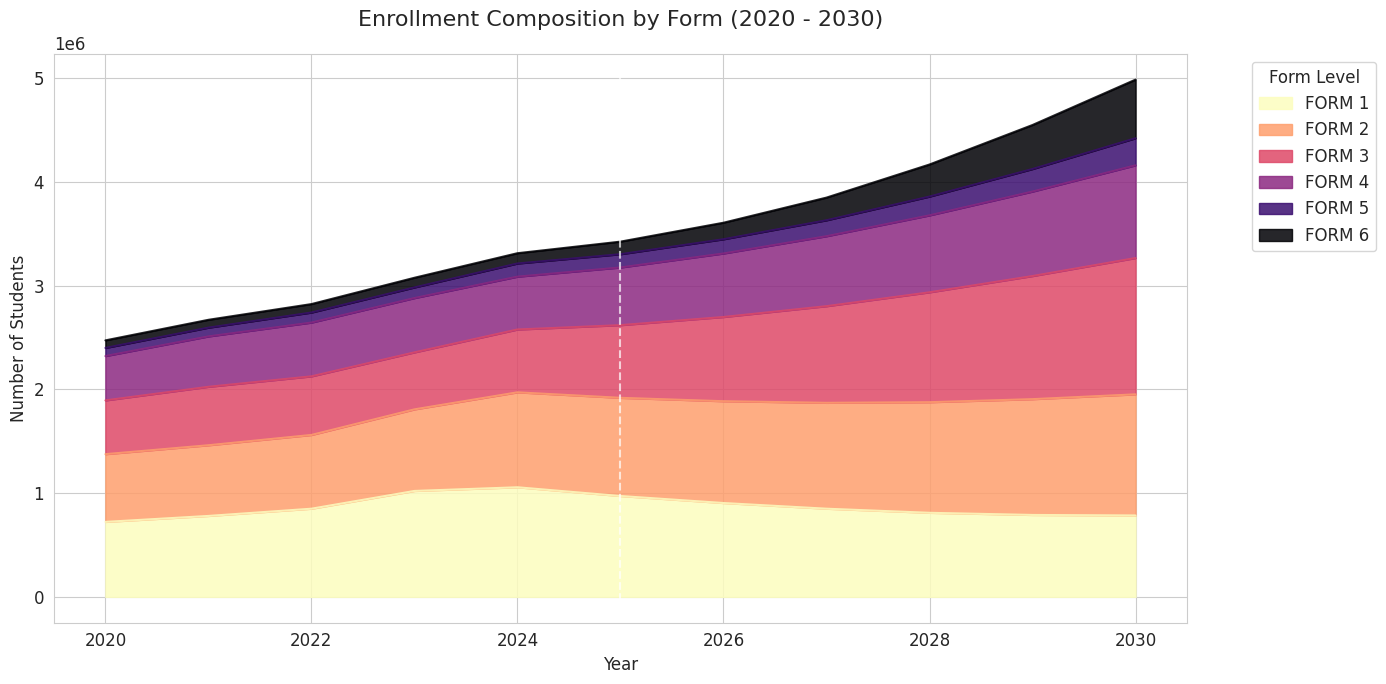

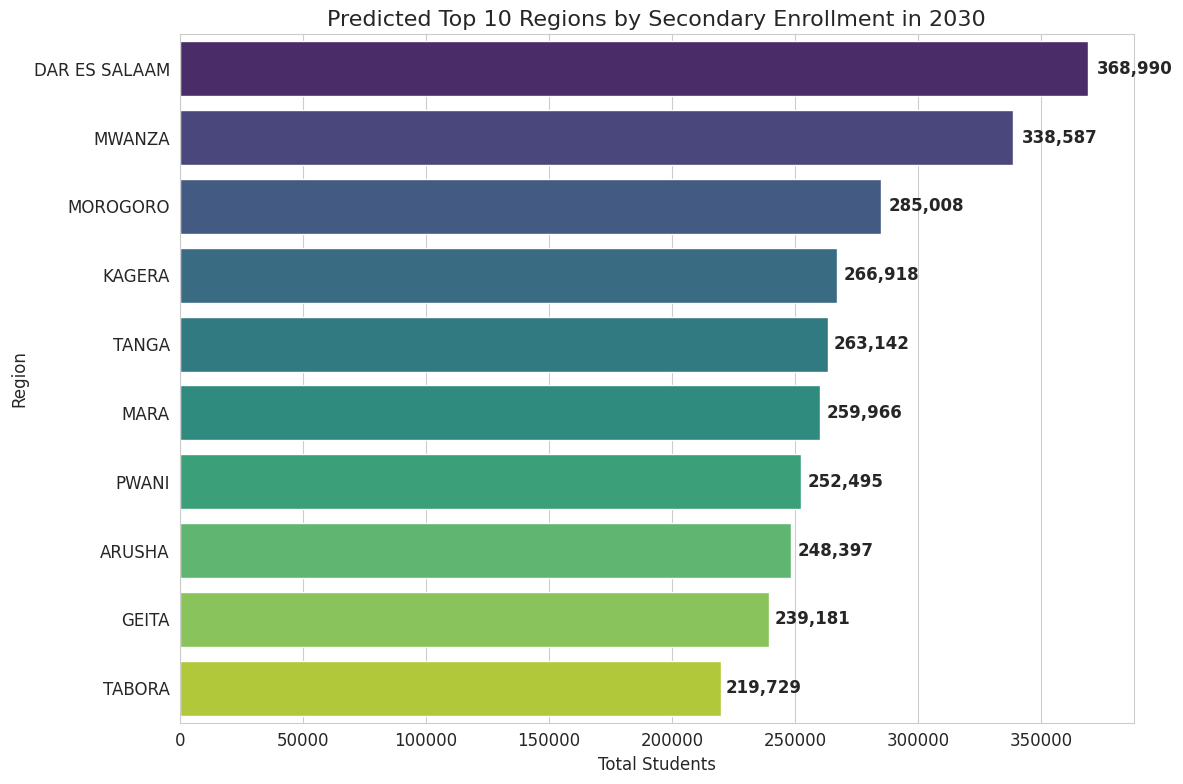


Success! Secondary Forecast data saved to 'Tanzania_MoEST_Secondary_Forecast_2026_2030.csv'


In [ ]:
# ==========================================
# MASTER EXECUTION BLOCK (SECONDARY SCHOOLS)
# ==========================================

# 1. TRAIN & PREPARE DATA
print("STEP 1: Training Models on 2016-2025 Data...")
# We capture the processed dataframe (secondary_final_df) and the models
secondary_final_df, sec_metrics, sec_model = run_secondary_pipeline(
    loaded_dataframes["Data-Secondary Enrollment 2016-2025"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 2. GENERATE FORECASTS (2026-2030)
print("\nSTEP 2: Generating Recursive Forecasts (Forms 1-6)...")
# This function retrains on the full dataset (no test split) for maximum predictive power
future_secondary_enrollment = run_secondary_prediction_pipeline(secondary_final_df)

# 3. SHOW HEAD OF FORECAST DATA
print("\nSTEP 3: Preview of Forecast Data (First 10 Rows):")
pd.set_option('display.max_columns', None)  # Ensure all columns are visible
print(future_secondary_enrollment.head(10))

# 4. PLOT & SAVE GRAPHS
print("\nSTEP 4: Generating and Saving Visualizations...")
# This generates the Trajectory, Stacked Area (Forms), and Regional Bar charts
plot_secondary_forecasts(secondary_final_df, future_secondary_enrollment)

# 5. EXPORT DATA TO CSV
csv_filename = "Tanzania_MoEST_Secondary_Forecast_2026_2030.csv"
future_secondary_enrollment.to_csv(csv_filename, index=False)
print(f"\nSuccess! Secondary Forecast data saved to '{csv_filename}'")

Saved: Secondary_Forecast_National_Trend.png


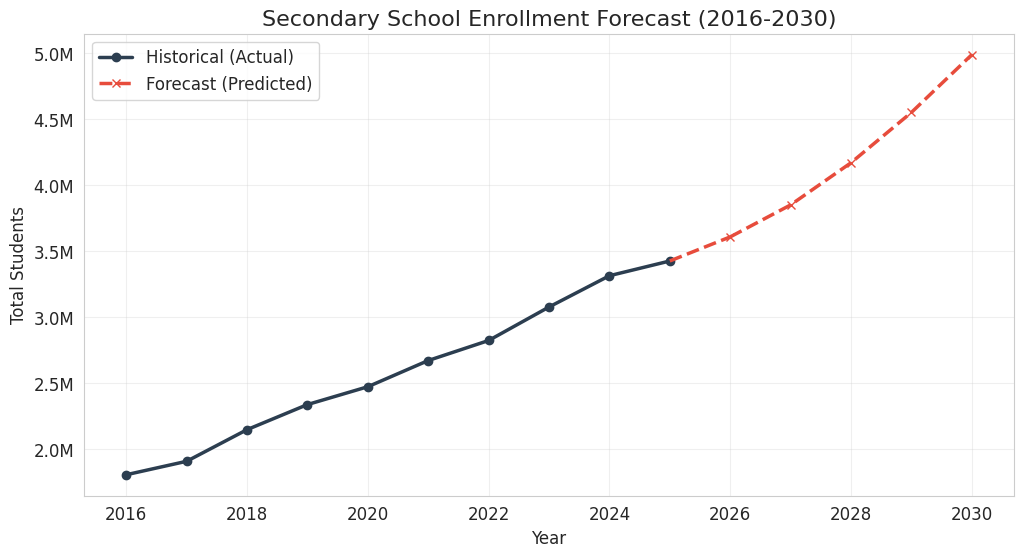

Saved: Secondary_Forecast_Form_Composition.png


<Figure size 1400x700 with 0 Axes>

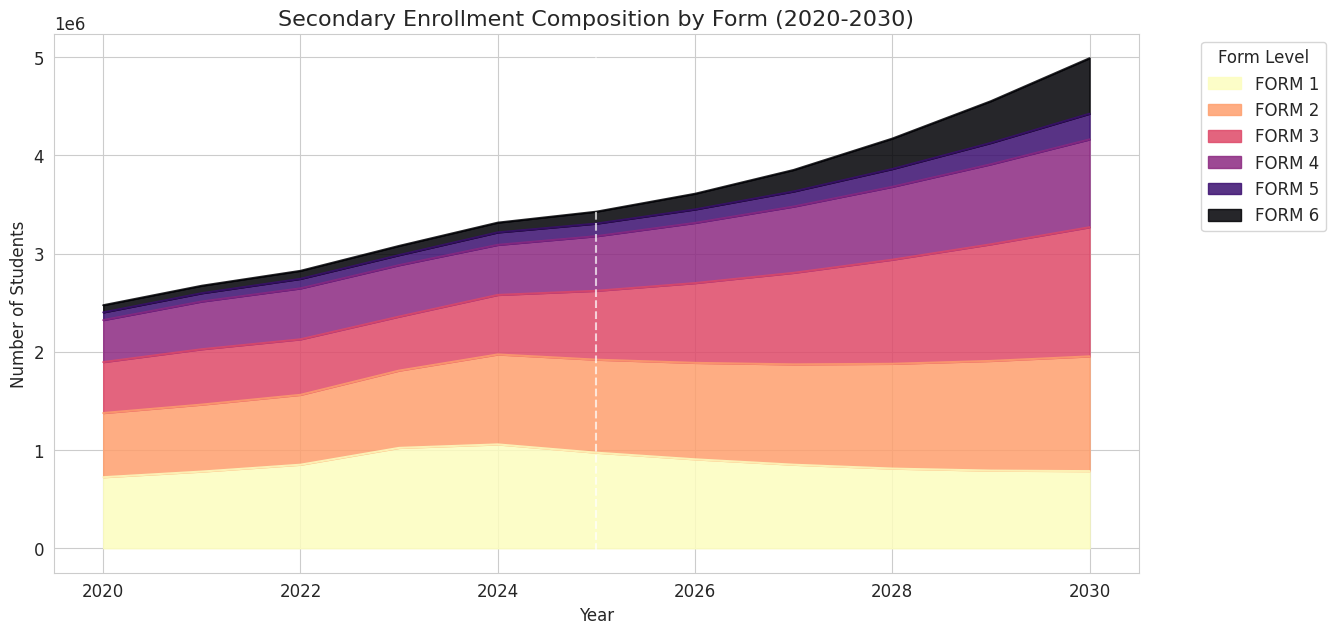

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_secondary_forecasts(history_df, forecast_df):
    """
    Plots historical vs. forecasted trends specifically for Secondary Schools.
    Saves the resulting charts as PNG files.
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # --- 1. PREPARE DATA ---
    # Extract relevant columns and tag them
    # Note: We use 'FORM' instead of 'GRADE' for Secondary data
    hist_clean = history_df[['YEAR', 'ENROLLMENT', 'FORM']].copy()
    hist_clean['Type'] = 'Historical'

    forc_clean = forecast_df[['YEAR', 'ENROLLMENT', 'FORM']].copy()
    forc_clean['Type'] = 'Forecast'

    full_data = pd.concat([hist_clean, forc_clean])

    # --- CHART 1: National Trend (Trajectory) ---
    plt.figure(figsize=(12, 6))

    # Aggregate total enrollment per year
    total_trend = full_data.groupby(['YEAR', 'Type'])['ENROLLMENT'].sum().reset_index()

    hist_trend = total_trend[total_trend['Type'] == 'Historical']
    forc_trend = total_trend[total_trend['Type'] == 'Forecast']

    # Plot Lines
    plt.plot(hist_trend['YEAR'], hist_trend['ENROLLMENT'],
             label='Historical (Actual)', color='#2c3e50', lw=2.5, marker='o')

    plt.plot(forc_trend['YEAR'], forc_trend['ENROLLMENT'],
             label='Forecast (Predicted)', color='#e74c3c', lw=2.5, ls='--', marker='x')

    # Connect the gap (Year 2025 -> 2026) to make the line continuous
    if not hist_trend.empty and not forc_trend.empty:
        plt.plot([hist_trend['YEAR'].max(), forc_trend['YEAR'].min()],
                 [hist_trend['ENROLLMENT'].iloc[-1], forc_trend['ENROLLMENT'].iloc[0]],
                 color='#e74c3c', ls='--', lw=2.5)

    plt.title('Secondary School Enrollment Forecast (2016-2030)', fontsize=16)
    plt.ylabel('Total Students')
    plt.xlabel('Year')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format Y-axis to Millions (e.g., 2.5M)
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])

    # Save and Show
    plt.savefig("Secondary_Forecast_National_Trend.png", dpi=300, bbox_inches='tight') # <--- SAVES IMAGE
    print("Saved: Secondary_Forecast_National_Trend.png")
    plt.show()

    # --- CHART 2: Form Breakdown (Stacked Area) ---
    plt.figure(figsize=(14, 7))

    # Define correct order for Secondary Schools
    form_order = ['FORM 1', 'FORM 2', 'FORM 3', 'FORM 4', 'FORM 5', 'FORM 6']

    # Filter for recent years (2020+) to focus on the trend
    recent_data = full_data[full_data['YEAR'] >= 2020].copy()

    # Pivot data: Rows=Year, Cols=Form, Values=Enrollment
    pivot_df = recent_data.groupby(['YEAR', 'FORM'])['ENROLLMENT'].sum().unstack()

    # Reindex columns to ensure correct order (F1 -> F6) and handle missing columns if any
    pivot_df = pivot_df.reindex(columns=form_order)

    # Plot Stacked Area
    pivot_df.plot.area(stacked=True, alpha=0.85, figsize=(14, 7), cmap='magma_r')
    # 'magma_r' gives a nice gradient from Form 1 to Form 6

    plt.title('Secondary Enrollment Composition by Form (2020-2030)', fontsize=16)
    plt.ylabel('Number of Students')
    plt.xlabel('Year')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Form Level")

    # Add vertical line for "Forecast Start"
    plt.axvline(x=2025, color='white', ls='--', label='Forecast Start', alpha=0.7)

    # Save and Show
    plt.savefig("Secondary_Forecast_Form_Composition.png", dpi=300, bbox_inches='tight') # <--- SAVES IMAGE
    print("Saved: Secondary_Forecast_Form_Composition.png")
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
# Run this using the variables from your Secondary pipeline:
plot_secondary_forecasts(secondary_final_df, future_secondary_enrollment)

In [ ]:
# ==========================================
# TRANSFORM SECONDARY FORECAST TO WIDE FORMAT
# ==========================================

# 1. Pivot the Data
# Index: The static columns (Region, Council, Form)
# Columns: The years (2026, 2027, etc.)
# Values: The enrollment numbers
wide_secondary_forecast = future_secondary_enrollment.pivot_table(
    index=['REGION', 'COUNCIL', 'FORM'],
    columns='YEAR',
    values='ENROLLMENT',
    aggfunc='sum' # Ensures we sum if there happen to be duplicate entries
)

# 2. Flatten the Column Headers
# This converts the column names from integers [2026, 2027] to strings ["2026", "2027"]
wide_secondary_forecast.columns = [str(col) for col in wide_secondary_forecast.columns]

# 3. Reset Index to make Region/Council/Form normal columns again
wide_secondary_forecast = wide_secondary_forecast.reset_index()

# 4. Sort for better readability (Region -> Council -> Form 1 to Form 6)
# Ensure forms are sorted logically (Form 1, 2... 6)
form_sorter = {'FORM 1': 1, 'FORM 2': 2, 'FORM 3': 3, 'FORM 4': 4, 'FORM 5': 5, 'FORM 6': 6}
wide_secondary_forecast['FORM_RANK'] = wide_secondary_forecast['FORM'].map(form_sorter)
wide_secondary_forecast = wide_secondary_forecast.sort_values(['REGION', 'COUNCIL', 'FORM_RANK'])
wide_secondary_forecast.drop(columns=['FORM_RANK'], inplace=True)

# 5. Display the Head
print("--- Wide Format Secondary Forecast (First 10 Rows) ---")
pd.set_option('display.max_columns', None)
print(wide_secondary_forecast.head(10))

# 6. Export to CSV
csv_filename = "Tanzania_Secondary_Forecast_2026_2030_WIDE.csv"
wide_secondary_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Wide-format Secondary data saved to '{csv_filename}'")

--- Wide Format Secondary Forecast (First 10 Rows) ---
   REGION    COUNCIL    FORM   2026   2027   2028   2029   2030
0  ARUSHA     ARUSHA  FORM 1   8275   7917   7613   7436   7188
1  ARUSHA     ARUSHA  FORM 2  10148  11499  13269  14510  15850
2  ARUSHA     ARUSHA  FORM 3   7169   7440   7790   8147   8662
3  ARUSHA     ARUSHA  FORM 4   6892   7691   8513   9527  10638
4  ARUSHA     ARUSHA  FORM 5   1142   1331   1559   1816   2126
5  ARUSHA     ARUSHA  FORM 6    949   1084   1158   1311   1502
6  ARUSHA  ARUSHA CC  FORM 1  11745  12288  12698  12720  12853
7  ARUSHA  ARUSHA CC  FORM 2  13186  14076  14849  14838  14025
8  ARUSHA  ARUSHA CC  FORM 3   9854  10351  10979  11693  12607
9  ARUSHA  ARUSHA CC  FORM 4   8645   9153   9779  10332  10947

Success! Wide-format Secondary data saved to 'Tanzania_Secondary_Forecast_2026_2030_WIDE.csv'



--- Running Pipeline to get Model Objects ---
1. Preparing Datasets...
2. Engineering Features...
3. Training Both Models...
Training XGBoost...
Training LightGBM...

Generating Feature Importance Comparison...
Graph saved as Secondary_Feature_Importance_Comparison.png


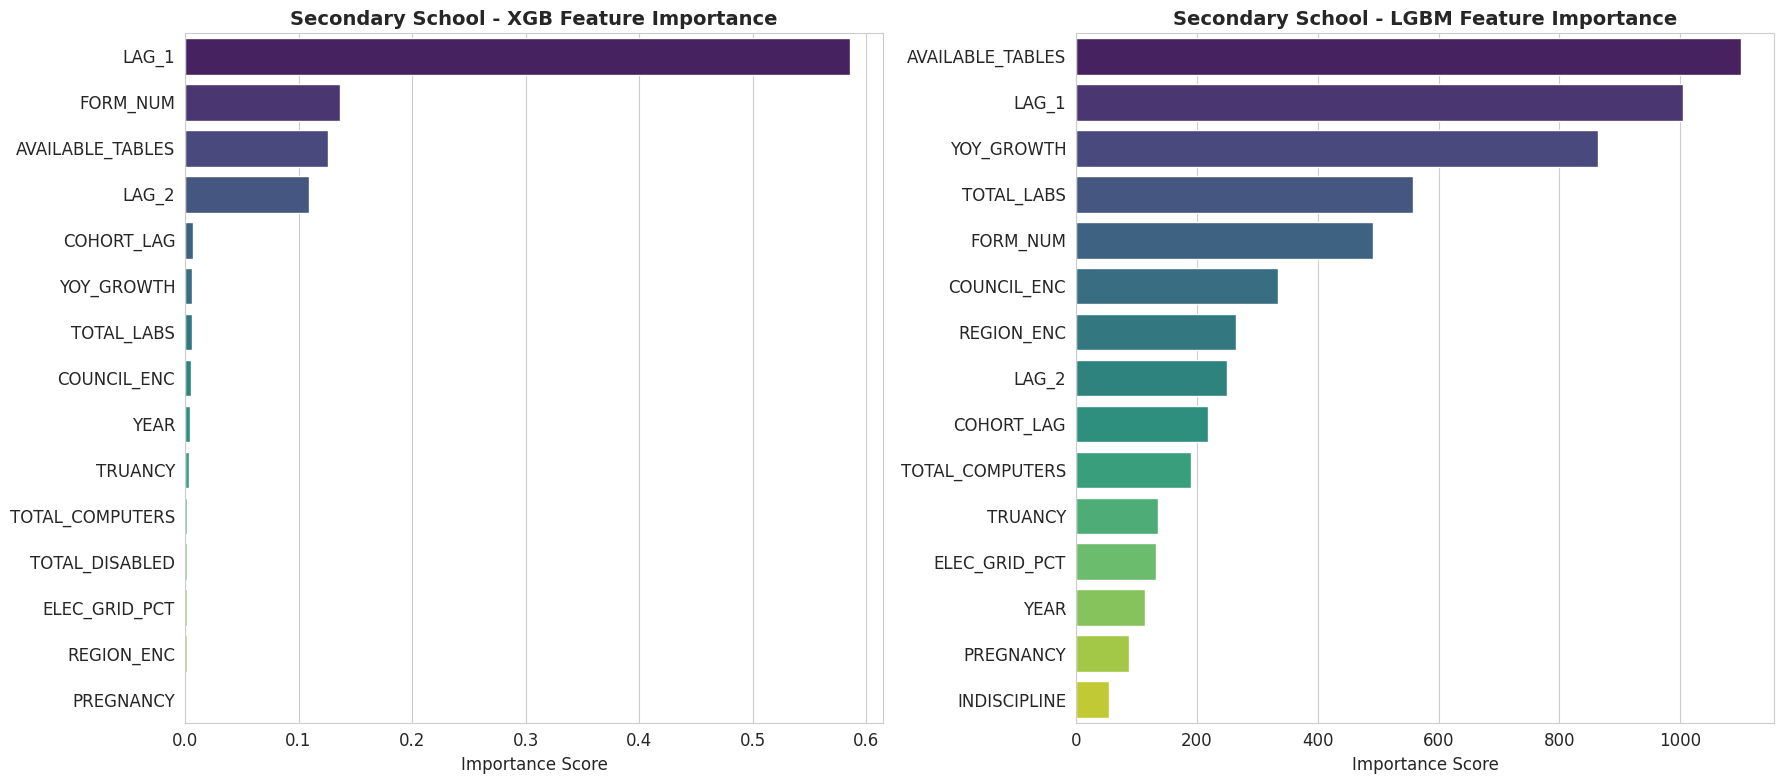

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. UPDATE TRAINING FUNCTION TO RETURN BOTH MODELS
# ==========================================
def train_secondary_models_both(df):
    """
    Trains both XGBoost and LightGBM and returns them in a dictionary.
    """
    le = LabelEncoder()
    df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))

    features = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Filter features
    features = [f for f in features if f in df.columns]

    train = df[df['YEAR'] < 2024]
    test = df[df['YEAR'] >= 2024]

    X_train, y_train = train[features], train['ENROLLMENT']
    X_test, y_test = test[features], test['ENROLLMENT']

    results = {}
    models = {} # <--- Dictionary to store both models

    # 1. XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=7, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    models['XGB'] = xgb_model

    # 2. LightGBM
    print("Training LightGBM...")
    lgb_model = lgb.LGBMRegressor(n_estimators=150, num_leaves=40, verbose=-1)
    lgb_model.fit(X_train, y_train)
    models['LGBM'] = lgb_model

    return results, models

# ==========================================
# 2. UPDATE PIPELINE TO CAPTURE MODEL DICTIONARY
# ==========================================
def run_secondary_pipeline_both(enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df):

    # Reuse the preparation functions defined earlier
    print("1. Preparing Datasets...")
    enroll, drops, tables, reentry, dis, ict, elec, labs = prepare_secondary_datasets(
        enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df
    )

    print("2. Engineering Features...")
    final_df = engineer_secondary_features(enroll, drops, tables, reentry, dis, ict, elec, labs)

    print("3. Training Both Models...")
    metrics, models = train_secondary_models_both(final_df)

    return final_df, models

# ==========================================
# 3. EXECUTION: GET MODELS & PLOT
# ==========================================

# A. Run Pipeline
print("\n--- Running Pipeline to get Model Objects ---")
sec_final_df, sec_models_dict = run_secondary_pipeline_both(
    loaded_dataframes["Data-Secondary Enrollment 2016-2025"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# B. Define Plotting Function (Original Style)
def plot_feature_importance(models_dict, model_names=['XGB', 'LGBM'], title_prefix=""):
    sns.set_style("whitegrid")

    # Setup Subplots
    fig, axes = plt.subplots(1, len(model_names), figsize=(18, 8))
    if len(model_names) == 1: axes = [axes]

    for i, name in enumerate(model_names):
        model = models_dict.get(name)
        if not model: continue

        # Extract Importances based on library
        if name == 'XGB':
            importance = model.feature_importances_
            feats = model.feature_names_in_
        elif name == 'LGBM':
            importance = model.feature_importances_
            feats = model.feature_name_
        else:
            continue

        # Create DataFrame & Sort
        imp_df = pd.DataFrame({'Feature': feats, 'Importance': importance})
        imp_df = imp_df.sort_values('Importance', ascending=False).head(15) # Top 15

        # Plot
        sns.barplot(data=imp_df, x='Importance', y='Feature', ax=axes[i], palette='viridis')
        axes[i].set_title(f'{title_prefix} - {name} Feature Importance', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Importance Score')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.savefig("Secondary_Feature_Importance_Comparison.png", dpi=300)
    print("Graph saved as Secondary_Feature_Importance_Comparison.png")
    plt.show()

# C. Generate the Graphs
print("\nGenerating Feature Importance Comparison...")
plot_feature_importance(sec_models_dict, title_prefix="Secondary School")

In [ ]:
import pandas as pd

# ==========================================
# MERGE HISTORY & FORECAST (SECONDARY SCHOOLS)
# ==========================================

# Define common columns for concatenation
# Note: Using 'FORM' instead of 'GRADE' for Secondary Schools
common_cols = ['YEAR', 'REGION', 'COUNCIL', 'FORM', 'ENROLLMENT']

# 1. Select common columns from the historical dataset (secondary_final_df)
# We ensure we only take the columns that match the forecast structure
historical_sec_selected = secondary_final_df[common_cols].copy()

# 2. Select common columns from the forecast dataset (future_secondary_enrollment)
forecast_sec_selected = future_secondary_enrollment[common_cols].copy()

# 3. Concatenate History + Forecast
total_secondary_enrollment_forecast = pd.concat([
    historical_sec_selected,
    forecast_sec_selected
], ignore_index=True)

# 4. Sort for clean reading
# Sort by Year -> Region -> Council -> Form
total_secondary_enrollment_forecast = total_secondary_enrollment_forecast.sort_values(
    ['YEAR', 'REGION', 'COUNCIL', 'FORM']
)

print("--- Combined Secondary Historical and Forecasted Data ---")
print("First 5 rows (Historical Start):")
print(total_secondary_enrollment_forecast.head())

print("\nLast 5 rows (Forecast End):")
print(total_secondary_enrollment_forecast.tail())

print("\nDataFrame Info:")
total_secondary_enrollment_forecast.info()

# 5. Optional: Export the Master Dataset
csv_filename = "Tanzania_Secondary_Master_Dataset_2016_2030.csv"
total_secondary_enrollment_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Master dataset saved to '{csv_filename}'")

--- Combined Secondary Historical and Forecasted Data ---
First 5 rows (Historical Start):
    YEAR  REGION COUNCIL    FORM  ENROLLMENT
0   2016  ARUSHA  ARUSHA  FORM 1        6950
10  2016  ARUSHA  ARUSHA  FORM 2        5797
20  2016  ARUSHA  ARUSHA  FORM 3        3958
30  2016  ARUSHA  ARUSHA  FORM 4        4928
40  2016  ARUSHA  ARUSHA  FORM 5         709

Last 5 rows (Forecast End):
       YEAR REGION   COUNCIL    FORM  ENROLLMENT
16531  2030  TANGA  TANGA CC  FORM 2        6757
16532  2030  TANGA  TANGA CC  FORM 3       11779
16533  2030  TANGA  TANGA CC  FORM 4        6957
16534  2030  TANGA  TANGA CC  FORM 5        1274
16535  2030  TANGA  TANGA CC  FORM 6        1207

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 16536 entries, 0 to 16535
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   YEAR        16536 non-null  int64 
 1   REGION      16536 non-null  object
 2   COUNCIL     16536 non-null  obj

In [ ]:
import pandas as pd

# ==========================================
# RANDOM SAMPLING OF COUNCILS (SECONDARY)
# ==========================================

total_selected = 24

# 1. Identify all unique 'REGION' and 'COUNCIL' combinations from the Master Secondary Dataset
unique_sec_councils = total_secondary_enrollment_forecast[['REGION', 'COUNCIL']].drop_duplicates()

# 2. Randomly sample 'total_selected' of these unique combinations
#    We use random_state=42 to ensure we get the same "random" councils every time we run this.
selected_sec_councils = unique_sec_councils.sample(n=total_selected, random_state=42)

# 3. Display the selected councils to verify
print(f"--- Randomly Selected {total_selected} Secondary School Councils ---")
print(selected_sec_councils)

# Optional: Store as a list of tuples for easy filtering later
# Example format: [('ARUSHA', 'ARUSHA CC'), ('DODOMA', 'BAHI DC'), ...]
selected_sec_councils_list = [tuple(row) for row in selected_sec_councils.values]

--- Randomly Selected 24 Secondary School Councils ---
            REGION              COUNCIL
1248         GEITA                CHATO
2628        KIGOMA              BUHIGWE
9522      SINGIDA            SINGIDA MC
6768        MWANZA              UKEREWE
9042        SIMIYU                MASWA
1008        DODOMA            KONDOA TC
1548        IRINGA               IRINGA
4188       MANYARA             MBULU TC
7128        NJOMBE         WANGING'OMBE
5988        MTWARA  MTWARA MIKINDANI MC
5928        MTWARA               MTWARA
9936        TABORA               KALIUA
4248       MANYARA            SIMANJIRO
10656        TANGA           KOROGWE TC
2808        KIGOMA            KASULU TC
1068        DODOMA               KONGWA
3168   KILIMANJARO                MOSHI
2208        KAGERA               MULEBA
5028         MBEYA              MBARALI
3468   KILIMANJARO                 SIHA
10056       TABORA             NZEGA TC
7602         PWANI             MKURANGA
8922        SIMIYU       

--- Generating Secondary Enrollment Plots for 24 Selected Councils (2016-2030) ---
Graph saved as 'Secondary_Selected_Councils_Trends.png'


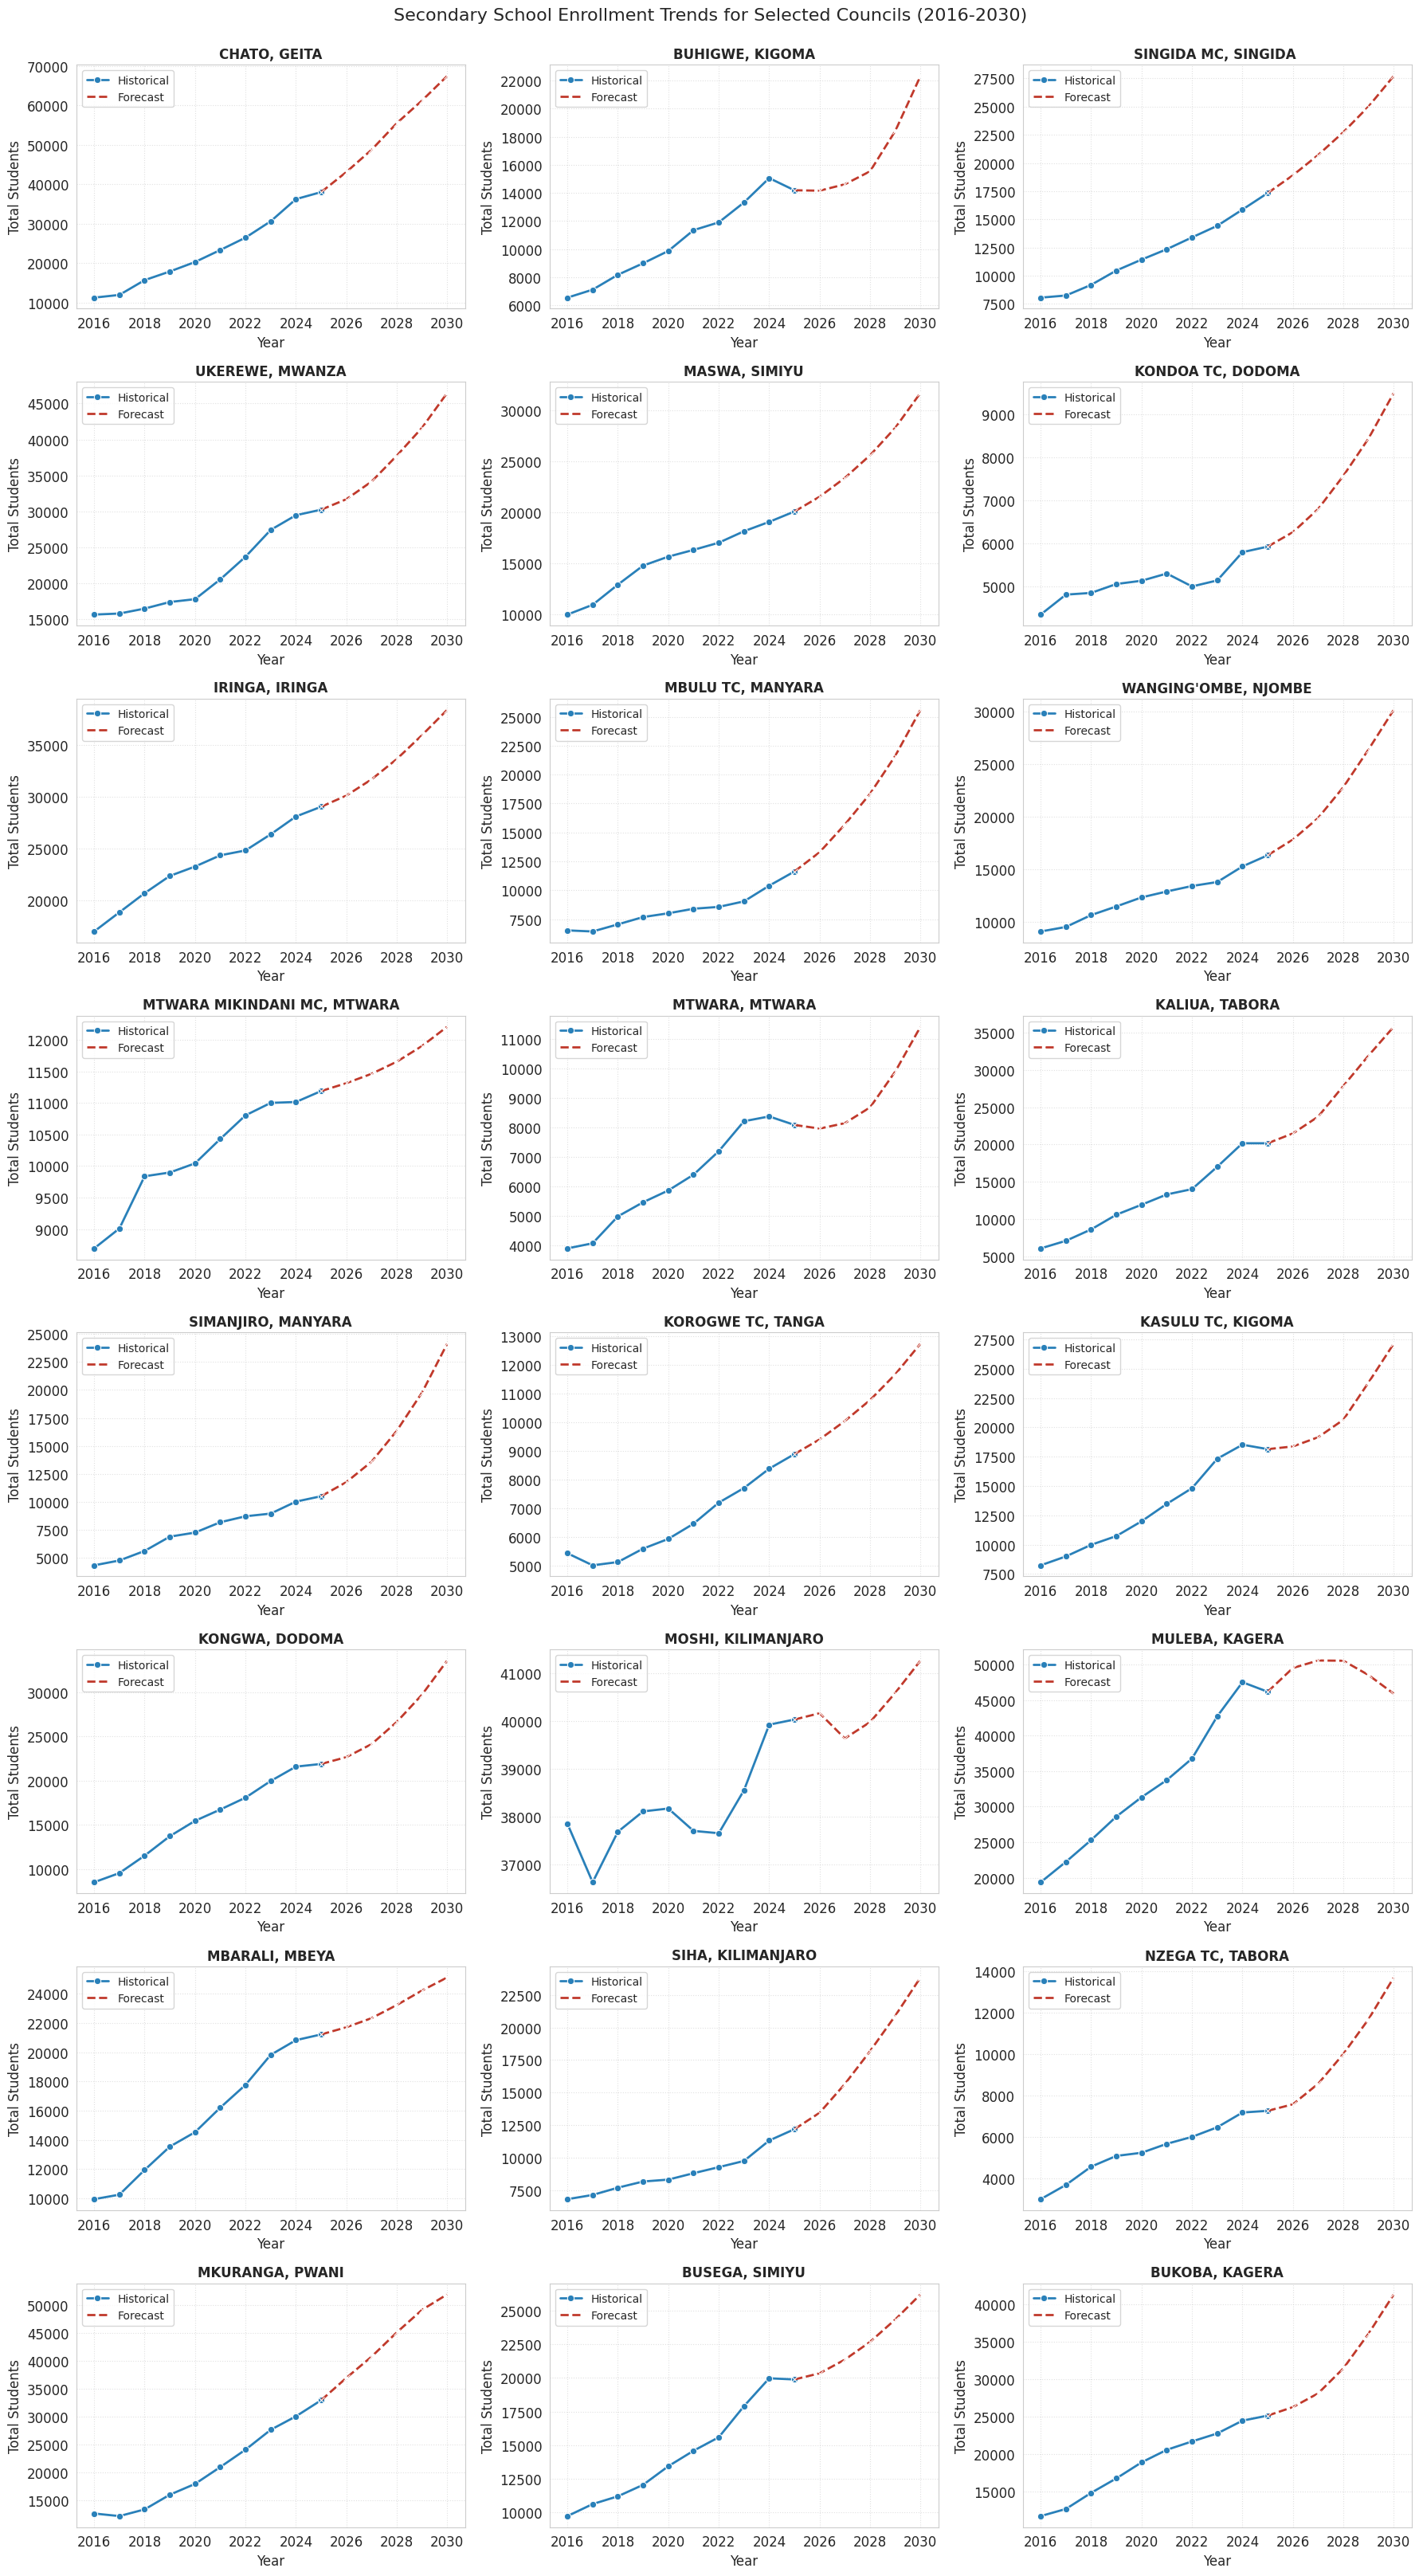

--- All secondary enrollment trend visualizations generated. ---


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported for ceil calculation

sns.set_style("whitegrid")

# ==========================================
# PLOT TRENDS FOR SELECTED SECONDARY COUNCILS
# ==========================================

# 1. Calculate total enrollment per year for each council
# Summing across all Forms (1-6) to get a single trend line per council
sec_council_totals = total_secondary_enrollment_forecast.groupby(['REGION', 'COUNCIL', 'YEAR'])['ENROLLMENT'].sum().reset_index()

# 2. Determine grid dimensions (3 columns wide)
num_councils = len(selected_sec_councils_list)
rows = int(np.ceil(num_councils / 3))
cols = 3

# 3. Initialize Figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), sharex=False, sharey=False)
axes = axes.flatten() # Flatten 2D array to 1D for easy iteration

print(f"--- Generating Secondary Enrollment Plots for {num_councils} Selected Councils (2016-2030) ---")

# 4. Loop through selected councils and plot
for i, (region, council) in enumerate(selected_sec_councils_list):
    ax = axes[i]

    # Filter data specific to this council
    council_data = sec_council_totals[
        (sec_council_totals['REGION'] == region) &
        (sec_council_totals['COUNCIL'] == council)
    ].sort_values('YEAR')

    # A. Plot Historical (Up to 2025)
    historical_data = council_data[council_data['YEAR'] <= 2025]
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical_data, ax=ax,
                 label='Historical', color='#2980b9', marker='o', linewidth=2)

    # B. Plot Forecast (2025 onwards to ensure connection)
    forecast_data = council_data[council_data['YEAR'] >= 2025]
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast_data, ax=ax,
                 label='Forecast', color='#c0392b', linestyle='--', marker='x', linewidth=2)

    # Formatting
    ax.set_title(f'{council}, {region}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Students')
    ax.legend(loc='upper left', fontsize='small')
    ax.grid(True, linestyle=':', alpha=0.6)

    # Improve X-axis ticks (every 2 years to avoid crowding)
    ax.set_xticks(np.arange(2016, 2031, 2))

# 5. Hide empty subplots if 24 doesn't fill the grid perfectly (though 24/3 = 8 rows exactly)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Secondary School Enrollment Trends for Selected Councils (2016-2030)', y=1.01, fontsize=16)

# Save the grid image
plt.savefig("Secondary_Selected_Councils_Trends.png", dpi=200, bbox_inches='tight')
print("Graph saved as 'Secondary_Selected_Councils_Trends.png'")

plt.show()

print("--- All secondary enrollment trend visualizations generated. ---")

In [ ]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import pandas as pd
import numpy as np
from folium import IFrame

# ---------------------------------------------------------
# 1. PREPARE SECONDARY DATA
# ---------------------------------------------------------
# First, ensure we have the aggregated totals per council (Summing Forms 1-6)
# We reuse the master dataset 'total_secondary_enrollment_forecast'
sec_council_totals = total_secondary_enrollment_forecast.groupby(
    ['REGION', 'COUNCIL', 'YEAR']
)['ENROLLMENT'].sum().reset_index()

# Filter to only include the 24 councils in 'selected_sec_councils_list'
selected_indices = [
    (row['REGION'], row['COUNCIL']) in selected_sec_councils_list
    for _, row in sec_council_totals.iterrows()
]
filtered_sec_forecast = sec_council_totals[selected_indices].copy()

# Merge with Geo Data to get Lat/Lon
# We group by Region/Council first to get one unique row per council for the map loop
sec_map_data = filtered_sec_forecast.groupby(['REGION', 'COUNCIL']).first().reset_index()

# NOTE: Assumes 'geo_data_final' exists in your environment with Lat/Lon
sec_map_data = pd.merge(
    sec_map_data,
    geo_data_final[['Region', 'Council', 'Latitude', 'Longitude']],
    left_on=['REGION', 'COUNCIL'],
    right_on=['Region', 'Council'],
    how='inner'
)

print(f"Matched coordinates for {len(sec_map_data)} out of {len(selected_sec_councils_list)} selected councils.")

# ---------------------------------------------------------
# 2. HELPER FUNCTION: PLOT TO HTML IMAGE
# ---------------------------------------------------------
def get_sec_plot_as_html(region, council, df_all):
    """
    Generates a matplotlib plot for a specific council and returns
    it as a base64 encoded HTML image string.
    """
    # Filter data for this specific council
    council_data = df_all[
        (df_all['REGION'] == region) &
        (df_all['COUNCIL'] == council)
    ].sort_values('YEAR')

    historical = council_data[council_data['YEAR'] <= 2025]
    forecast = council_data[council_data['YEAR'] >= 2025] # Overlap 2025 for continuity

    # Create figure (smaller size for popup)
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plotting (Blue for History, Red for Forecast)
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical, ax=ax,
                 label='Hist', color='#2980b9', marker='o', markersize=4)
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast, ax=ax,
                 label='Fcst', color='#c0392b', linestyle='--', marker='x', markersize=4)

    # Styling
    ax.set_title(f'{council} Secondary Trend', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(fontsize=8, loc='upper left')

    # Improve X-axis ticks (skip every other year if crowded)
    ax.set_xticks(np.arange(2016, 2031, 2))

    plt.tight_layout()

    # Save plot to PNG image in memory
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight', dpi=100)
    plt.close(fig) # Close to free memory
    img.seek(0)

    # Encode to Base64 string
    encoded = base64.b64encode(img.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{encoded}">'
    return html

# ---------------------------------------------------------
# 3. GENERATE MAP
# ---------------------------------------------------------
# Center map on Tanzania
sec_forecast_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6, tiles='CartoDB positron')

print("Generating map with embedded secondary plots... this may take a moment.")

for idx, row in sec_map_data.iterrows():
    reg = row['REGION']
    coun = row['COUNCIL']
    lat = row['Latitude']
    lon = row['Longitude']

    # Generate the plot HTML for this specific council using the full trend data
    plot_html = get_sec_plot_as_html(reg, coun, filtered_sec_forecast)

    # Create an IFrame to hold the image
    iframe = IFrame(plot_html, width=520, height=320)
    popup = folium.Popup(iframe, max_width=550)

    # Add Marker (Purple color to distinguish from Primary Schools)
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        tooltip=f"{coun} (Secondary Forecast)",
        icon=folium.Icon(color='purple', icon='graduation-cap', prefix='fa')
    ).add_to(sec_forecast_map)

print("Secondary School Map generated successfully.")

# ---------------------------------------------------------
# 4. SAVE & DISPLAY MAP
# ---------------------------------------------------------
# Save to HTML file
sec_forecast_map.save("Secondary_Enrollment_Forecast_Map.html")
print("Map saved to 'Secondary_Enrollment_Forecast_Map.html'")

# Display in Notebook
sec_forecast_map

Matched coordinates for 23 out of 24 selected councils.
Generating map with embedded secondary plots... this may take a moment.
Secondary School Map generated successfully.
Map saved to 'Secondary_Enrollment_Forecast_Map.html'
